# Accessing the contents of polygon files in each video folder. 

In [ ]:
import os
import glob
import re
import shutil
import random
from pathlib import Path

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


Keys in the MATLAB file: dict_keys(['__header__', '__version__', '__globals__', 'polygons'])

Key: polygons
Type: <class 'numpy.ndarray'>
Shape: (1, 100)
Data type: [('myleft', 'O'), ('myright', 'O'), ('yourleft', 'O'), ('yourright', 'O')]
Dimensions: 2
Sample data structure:
[(array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64), array([[692.62371134, 487.84020619],
        [684.70618557, 493.1185567 ],
        [680.74742268, 493.1185567 ],
        [676.78865979, 493.1185567 ],
        [675.46907216, 494.43814433],
        [672.82989691, 494.43814433],
        [668.87113402, 494.43814433],
        [666.23195876, 495.75773196],
        [662.27319588, 497.07731959],
        [659.63402062, 497.07731959],
        [656.99484536, 498.39690722],
        [655.67525773, 498.39690722],
        [654.3556701 , 499.71649485],
        [651.71649485, 502.3556701 ],
        [650.39690722, 502.3556701 ],
        [650.39690722, 504.99484536],
        [647.75773196, 508.9536082

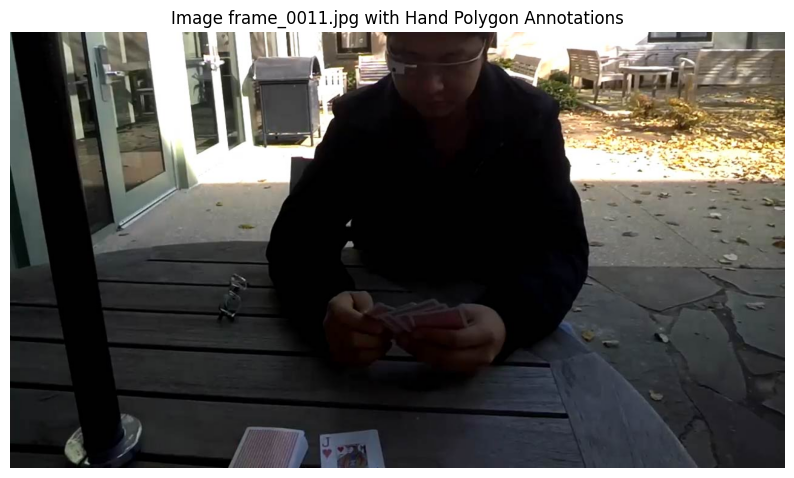

In [3]:
# Path to the specific polygon file
polygon_file_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_data\_LABELLED_SAMPLES\CARDS_COURTYARD_B_T\polygons.mat"
folder_path = os.path.dirname(polygon_file_path)

# Load the MATLAB file
mat_data = sio.loadmat(polygon_file_path)

# Print the keys in the MATLAB file
print("Keys in the MATLAB file:", mat_data.keys())

# Exclude standard MATLAB keys
relevant_keys = [key for key in mat_data.keys() if not key.startswith('__')]

# Print detailed information about each key
for key in relevant_keys:
    print(f"\nKey: {key}")
    print(f"Type: {type(mat_data[key])}")
    print(f"Shape: {mat_data[key].shape if hasattr(mat_data[key], 'shape') else 'No shape attribute'}")
    
    # If it's an array, show more detailed information
    if isinstance(mat_data[key], np.ndarray):
        print(f"Data type: {mat_data[key].dtype}")
        print(f"Dimensions: {mat_data[key].ndim}")
        
        # Print sample data based on dimensionality
        print("Sample data structure:")
        if mat_data[key].ndim == 1:
            print(mat_data[key][:5] if mat_data[key].size > 5 else mat_data[key])
        elif mat_data[key].ndim == 2:
            print(mat_data[key][0][:5] if mat_data[key].shape[1] > 5 else mat_data[key][0])
        elif mat_data[key].ndim == 3:
            print(f"First item shape: {mat_data[key][0].shape}")
            if isinstance(mat_data[key][0, 0], np.ndarray):
                print(f"Element type: {type(mat_data[key][0, 0])}")
                print(f"Element shape: {mat_data[key][0, 0].shape if hasattr(mat_data[key][0, 0], 'shape') else 'No shape'}")
        
        # For object arrays, inspect the first few objects
        if mat_data[key].dtype == np.dtype('O'):
            print("Object array detected. Inspecting first few elements:")
            for i in range(min(3, mat_data[key].size)):
                element = mat_data[key][i]
                print(f"  Element {i}:")
                print(f"    Type: {type(element)}")
                if hasattr(element, 'shape'):
                    print(f"    Shape: {element.shape}")
                if isinstance(element, np.ndarray) and element.size > 0:
                    print(f"    First few values: {element.flatten()[:5]}")

# Function to deeply explore the polygons data structure
def explore_polygons(polygons_data):
    print("\nExploring polygons data structure in detail:")
    
    if not isinstance(polygons_data, np.ndarray):
        print(f"Not a numpy array but a {type(polygons_data)}")
        return
    
    print(f"Overall shape: {polygons_data.shape}")
    print(f"Data type: {polygons_data.dtype}")
    
    # If it's an object array, explore each element
    if polygons_data.dtype == np.dtype('O'):
        for i in range(min(2, polygons_data.shape[0])):
            print(f"\nFrame {i}:")
            frame_data = polygons_data[i]
            
            if isinstance(frame_data, np.ndarray):
                print(f"  Type: {type(frame_data)}")
                print(f"  Shape: {frame_data.shape if hasattr(frame_data, 'shape') else 'No shape'}")
                
                # If it's a 2D array or another object array, explore further
                if frame_data.ndim > 1 or frame_data.dtype == np.dtype('O'):
                    for j in range(min(4, frame_data.shape[0] if hasattr(frame_data, 'shape') else 0)):
                        print(f"  Hand {j}:")
                        hand_data = frame_data[j]
                        print(f"    Type: {type(hand_data)}")
                        if hasattr(hand_data, 'shape'):
                            print(f"    Shape: {hand_data.shape}")
                        if isinstance(hand_data, np.ndarray) and hand_data.size > 0:
                            if hand_data.ndim == 1:
                                print(f"    Values: {hand_data[:10]}")
                            else:
                                print(f"    First few points: {hand_data[:3]}")
    else:
        # For non-object arrays, show the structure differently
        print("Regular numpy array. Showing first frame structure:")
        if polygons_data.ndim >= 2:
            print(polygons_data[0])

# Function to visualize polygons on an image after understanding the structure
def visualize_polygons(image_path, polygons_data, frame_idx=0):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    
    # Define colors for different hands
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    # Get the polygon data for this frame
    try:
        frame_data = polygons_data[frame_idx]
        print(f"Frame data type: {type(frame_data)}")
        print(f"Frame data shape: {frame_data.shape if hasattr(frame_data, 'shape') else 'No shape'}")
        
        # If frame_data is an object array or has multiple rows, it might contain multiple hand polygons
        if hasattr(frame_data, 'shape') and frame_data.shape[0] > 0:
            # Number of hand polygons in this frame
            num_hands = frame_data.shape[0] if frame_data.ndim > 1 else 1
            
            for hand_idx in range(num_hands):
                try:
                    # Get the polygon for this hand
                    hand_polygon = frame_data[hand_idx] if num_hands > 1 else frame_data
                    print(f"Hand {hand_idx} polygon type: {type(hand_polygon)}")
                    print(f"Hand {hand_idx} polygon shape: {hand_polygon.shape if hasattr(hand_polygon, 'shape') else 'No shape'}")
                    
                    # If this is a valid polygon with coordinates
                    if isinstance(hand_polygon, np.ndarray) and hand_polygon.size > 0:
                        # Adjust extraction based on the actual structure
                        # If hand_polygon is 2D with shape (N, 2), it has x,y coordinates
                        if hand_polygon.ndim == 2 and hand_polygon.shape[1] == 2:
                            polygon_points = [(x, y) for x, y in hand_polygon]
                        # If it's 1D, reshape it based on expected structure (assuming pairs are x,y)
                        elif hand_polygon.ndim == 1 and hand_polygon.size % 2 == 0:
                            hand_polygon = hand_polygon.reshape(-1, 2)
                            polygon_points = [(x, y) for x, y in hand_polygon]
                        else:
                            print(f"Unsupported polygon format for hand {hand_idx}")
                            continue
                        
                        # Draw polygon
                        if polygon_points:
                            draw.polygon(polygon_points, outline=colors[hand_idx % len(colors)])
                except Exception as e:
                    print(f"Error processing hand {hand_idx}: {e}")
        
    except Exception as e:
        print(f"Error processing frame {frame_idx}: {e}")
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(img))
    plt.title(f"Image {os.path.basename(image_path)} with Hand Polygon Annotations")
    plt.axis('off')
    plt.show()

# Explore the polygons data structure
if 'polygons' in mat_data:
    explore_polygons(mat_data['polygons'])

# Get a list of image files in the same folder
image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.png"))

if image_files and 'polygons' in mat_data:
    # Sort images by frame number to ensure we're getting them in order
    image_files.sort()
    
    # Get the first image
    first_image = image_files[0]
    print(f"Visualizing polygons on image: {os.path.basename(first_image)}")
    
    # Extract frame number from the image filename using regex
    match = re.search(r'frame_(\d+)', os.path.basename(first_image))
    if match:
        frame_number = int(match.group(1))
        print(f"Frame number: {frame_number}")
        
        # Adjust frame number to 0-based indexing if needed
        frame_idx = frame_number
        if frame_idx >= mat_data['polygons'].shape[0]:
            # Try with 0-based indexing
            frame_idx = frame_number - 1
            
        if frame_idx >= mat_data['polygons'].shape[0] or frame_idx < 0:
            print(f"Warning: Frame number {frame_idx} is out of bounds for polygons array with shape {mat_data['polygons'].shape}")
            print("Using first frame index (0) instead.")
            frame_idx = 0
        
        # Visualize the polygons
        visualize_polygons(first_image, mat_data['polygons'], frame_idx)
    else:
        print(f"Could not extract frame number from filename: {os.path.basename(first_image)}")
        # Fall back to using the first frame
        visualize_polygons(first_image, mat_data['polygons'], 0)
else:
    if not image_files:
        print("No image files found in the folder")
    if 'polygons' not in mat_data:
        print("No 'polygons' key found in the MATLAB file")

In [ ]:
# extracting .txt files for yolo from the metadata file 

In [ ]:
def convert_egohands_to_yolo():
    # Define paths
    egohands_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_data"
    output_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo"
    
    # Create output directories
    os.makedirs(os.path.join(output_dir, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val", "labels"), exist_ok=True)
    
    # Load central metadata file
    metadata_path = os.path.join(egohands_dir, "metadata.mat")
    metadata = sio.loadmat(metadata_path)
    videos = metadata["video"][0]  # Array of video info
    
    print(f"Loaded {len(videos)} videos from metadata")
    
    # Create 80-20 train-validation split
    num_videos = len(videos)
    indices = list(range(num_videos))
    random.seed(42)  # For reproducibility
    random.shuffle(indices)
    
    split_idx = int(num_videos * 0.8)  # 80% for training
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    print(f"Split: {len(train_indices)} videos for training, {len(val_indices)} videos for validation")
    
    # Process videos and create YOLO format files
    process_videos(videos, train_indices, val_indices, egohands_dir, output_dir)
    
    # Create data.yaml file
    data_yaml = f"""path: {output_dir}
train: train/images
val: val/images

nc: 1  # Number of classes
names: ['hand']  # Class names
"""
    
    with open(os.path.join(output_dir, "data.yaml"), 'w') as f:
        f.write(data_yaml)
    
    print("Conversion complete!")

In [ ]:
def normalize_coordinates(coords, img_width, img_height):
    """Normalize polygon coordinates to 0-1 range for YOLO format"""
    norm_coords = coords.copy()
    norm_coords[:, 0] = coords[:, 0] / img_width
    norm_coords[:, 1] = coords[:, 1] / img_height
    return norm_coords

In [4]:
def process_videos(videos, train_indices, val_indices, egohands_dir, output_dir):
    img_width, img_height = 1280, 720
    
    # Define class mapping - using single class approach
    class_map = {
        'myleft': 0,
        'myright': 0,
        'yourleft': 0,
        'yourright': 0
    }
    
    # Track statistics
    total_frames = 0
    total_hands = 0
    
    # Process each video
    for video_idx, video in enumerate(videos):
        video_id = video['video_id'][0]
        print(f"Processing video {video_id} ({video_idx+1}/{len(videos)})")
        
        # Determine if video belongs to train or val set
        if video_idx in train_indices:
            subset = "train"
        elif video_idx in val_indices:
            subset = "val"
        else:
            # This should not happen with our complete split
            print(f"  Warning: Video {video_id} not in train or val set, skipping")
            continue
        
        # Process each labeled frame
        labeled_frames = video['labelled_frames'][0]
        for frame_idx, frame_data in enumerate(labeled_frames):
            # Get frame number and path
            frame_num = frame_data['frame_num'][0][0]
            frame_path = os.path.join(egohands_dir, "_LABELLED_SAMPLES", video_id, f"frame_{frame_num:04d}.jpg")
            
            # Skip if frame doesn't exist
            if not os.path.exists(frame_path):
                print(f"  Warning: Frame {frame_path} not found, skipping")
                continue
            
            # Copy image to output directory
            img_filename = f"{video_id}_{frame_num:04d}.jpg"
            img_output_path = os.path.join(output_dir, subset, "images", img_filename)
            shutil.copy(frame_path, img_output_path)
            
            # Create label file
            label_filename = f"{video_id}_{frame_num:04d}.txt"
            label_output_path = os.path.join(output_dir, subset, "labels", label_filename)
            
            frame_hand_count = 0
            
            with open(label_output_path, 'w') as f:
                # Process each hand type
                for hand_type in ['myleft', 'myright', 'yourleft', 'yourright']:
                    if hand_type in frame_data.dtype.names and frame_data[hand_type].size > 0:
                        # Get hand polygon coordinates
                        hand_coords = frame_data[hand_type]
                        
                        # Normalize coordinates
                        norm_coords = normalize_coordinates(hand_coords, img_width, img_height)
                        
                        # Write to file in YOLO format: class_id x1 y1 x2 y2 ... xn yn
                        class_id = class_map[hand_type]
                        coords_str = ' '.join(f"{x:.6f} {y:.6f}" for x, y in norm_coords)
                        f.write(f"{class_id} {coords_str}\n")
                        
                        frame_hand_count += 1
            
            total_frames += 1
            total_hands += frame_hand_count
    
    print(f"Processed {total_frames} frames with {total_hands} hand instances")
    print(f"Training set: {len(train_indices)} videos")
    print(f"Validation set: {len(val_indices)} videos")

if __name__ == "__main__":
    convert_egohands_to_yolo()

Loaded 48 videos from metadata
Split: 38 videos for training, 10 videos for validation
Processing video CARDS_COURTYARD_B_T (1/48)
Processing video CARDS_COURTYARD_H_S (2/48)
Processing video CARDS_COURTYARD_S_H (3/48)
Processing video CARDS_COURTYARD_T_B (4/48)
Processing video CARDS_LIVINGROOM_B_T (5/48)
Processing video CARDS_LIVINGROOM_H_S (6/48)
Processing video CARDS_LIVINGROOM_S_H (7/48)
Processing video CARDS_LIVINGROOM_T_B (8/48)
Processing video CARDS_OFFICE_B_S (9/48)
Processing video CARDS_OFFICE_H_T (10/48)
Processing video CARDS_OFFICE_S_B (11/48)
Processing video CARDS_OFFICE_T_H (12/48)
Processing video CHESS_COURTYARD_B_T (13/48)
Processing video CHESS_COURTYARD_H_S (14/48)
Processing video CHESS_COURTYARD_S_H (15/48)
Processing video CHESS_COURTYARD_T_B (16/48)
Processing video CHESS_LIVINGROOM_B_S (17/48)
Processing video CHESS_LIVINGROOM_H_T (18/48)
Processing video CHESS_LIVINGROOM_S_B (19/48)
Processing video CHESS_LIVINGROOM_T_H (20/48)
Processing video CHESS_OFF

# Training YOLOv8m-seg model for hands and gesture detection.

In [1]:
# Install required packages if not already installed
!pip install ultralytics
!pip install opencv-python matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# second attempt to revert to the best weights

In [1]:
# Import necessary libraries
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display, Image
import yaml
import cv2
import numpy as np

# Set paths
data_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo"
yaml_path = os.path.join(data_path, "data.yaml")

# Display dataset info from YAML file
with open(yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)
    print("Dataset Information:")
    print(f"- Training images: {data_yaml.get('path')}/{data_yaml.get('train')}")
    print(f"- Validation images: {data_yaml.get('path')}/{data_yaml.get('val')}")
    print(f"- Number of classes: {data_yaml.get('nc')}")
    print(f"- Class names: {data_yaml.get('names')}")

# Initialize the YOLOv8 segmentation model
model = YOLO("yolov8m-seg.pt")

# Set training parameters specifically optimized for segmentation
results = model.train(
    data=yaml_path,          # Path to data YAML file
    epochs=50,               # Number of training epochs
    imgsz=640,               # Image size for training
    batch=16,                # Batch size (adjust based on your GPU)
    patience=15,             # Early stopping patience
    save=True,               # Save trained model
    device=0,                # GPU device (use 0 for first GPU, 'cpu' for CPU)
    workers=4,               # Number of worker threads
    project="hand_segmentation",  # Project name
    name="yolov8m_egohands_seg",  # Experiment name
    exist_ok=True,           # Overwrite existing experiment
    pretrained=True,         # Use pretrained weights
    optimizer="Adam",        # Optimizer
    lr0=0.001,               # Initial learning rate
    lrf=0.01,                # Final learning rate ratio
    momentum=0.937,          # SGD momentum/Adam beta1
    weight_decay=0.0005,     # Optimizer weight decay
    warmup_epochs=3.0,       # Warmup epochs
    warmup_momentum=0.8,     # Warmup initial momentum
    warmup_bias_lr=0.1,      # Warmup initial bias learning rate
    augment=True,            # Use augmentation
    rect=False,              # Rectangular training
    cos_lr=True,             # Cosine learning rate scheduler
    verbose=True,            # Verbose output
    seed=42,                 # Random seed
    task='segment',          # Specifically set the task to segment
    overlap_mask=True,       # Allow masks to overlap
    mask_ratio=4,            # Mask downsample ratio
    iou=0.7                  # IoU threshold
)

# Create custom plots instead of using results.plot_results
def plot_training_results(results_dict):
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Create titles for subplots
    titles = ['Loss', 'Segmentation mAP50', 'Segmentation mAP50-95', 'Precision-Recall']
    
    # Extract data from results dictionary
    epochs = list(range(1, len(results_dict['train/box_loss']) + 1))
    box_loss = results_dict['train/box_loss']
    seg_loss = results_dict['train/seg_loss']
    map50 = results_dict['metrics/mAP50(B)']
    map50_95 = results_dict['metrics/mAP50-95(B)']
    seg_map50 = results_dict['metrics/mAP50(M)']
    seg_map50_95 = results_dict['metrics/mAP50-95(M)']
    
    # Plot Loss
    axs[0, 0].plot(epochs, box_loss, label='Box Loss')
    axs[0, 0].plot(epochs, seg_loss, label='Seg Loss')
    axs[0, 0].set_title(titles[0])
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    # Plot Segmentation mAP50
    axs[0, 1].plot(epochs, seg_map50, label='Seg mAP50')
    axs[0, 1].set_title(titles[1])
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('mAP50')
    axs[0, 1].legend()
    
    # Plot Segmentation mAP50-95
    axs[1, 0].plot(epochs, seg_map50_95, label='Seg mAP50-95')
    axs[1, 0].set_title(titles[2])
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('mAP50-95')
    axs[1, 0].legend()
    
    # Plot Precision vs Recall for last epoch
    if 'metrics/precision(B)' in results_dict and 'metrics/recall(B)' in results_dict:
        precision = results_dict['metrics/precision(B)'][-1]
        recall = results_dict['metrics/recall(B)'][-1]
        axs[1, 1].scatter(recall, precision, color='blue', label='Box')
    
    if 'metrics/precision(M)' in results_dict and 'metrics/recall(M)' in results_dict:
        mask_precision = results_dict['metrics/precision(M)'][-1]
        mask_recall = results_dict['metrics/recall(M)'][-1]
        axs[1, 1].scatter(mask_recall, mask_precision, color='red', label='Mask')
        
    axs[1, 1].set_title(titles[3])
    axs[1, 1].set_xlabel('Recall')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].set_xlim(0, 1)
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].legend()
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('2_hand_segmentation/yolov8m_egohands_seg/training_results.png')
    plt.show()

# Try to plot training results safely with error handling
try:
    results_dict = results.results_dict
    plot_training_results(results_dict)
except Exception as e:
    print(f"Note: Custom plotting completed instead of automatic plotting. Original error: {e}")
    
# Display training metrics
print("\nSegmentation Training Results:")
try:
    print(f"Segmentation mAP50: {results.results_dict.get('metrics/mAP50(M)', [-1])[-1]:.4f}")
    print(f"Segmentation mAP50-95: {results.results_dict.get('metrics/mAP50-95(M)', [-1])[-1]:.4f}")
    print(f"Mask Precision: {results.results_dict.get('metrics/precision(M)', [-1])[-1]:.4f}")
    print(f"Mask Recall: {results.results_dict.get('metrics/recall(M)', [-1])[-1]:.4f}")
except Exception as e:
    print("Could not extract detailed metrics. Error:", e)

# Load the best model for validation and testing
print("\nLoading best model weights for validation...")
best_model_path = f"hand_segmentation/yolov8m_egohands_seg/weights/best.pt"

# Test the model on a few sample images with visualization of the segmentation masks
def test_segmentation_on_samples(model_path, num_samples=5):
    # Load the trained segmentation model
    model = YOLO(model_path)
    
    # Get some sample images from validation set
    val_img_dir = os.path.join(data_path, "val", "images")
    sample_images = os.listdir(val_img_dir)[:num_samples]
    
    plt.figure(figsize=(20, 16))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(val_img_dir, img_name)
        
        # Run prediction with the model
        results = model.predict(img_path, conf=0.25, save=False)
        
        # Get the original image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create a subplot with two images side by side (original and segmented)
        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(img)
        plt.title(f"Original: {img_name}")
        plt.axis('off')
        
        # Visualize segmentation masks
        plt.subplot(num_samples, 2, i*2+2)
        
        # Create a copy of the image for visualization
        segmented_img = img.copy()
        
        # Check if there are any detections
        if hasattr(results[0], 'masks') and results[0].masks is not None:
            # Get the segmentation mask
            for j, mask in enumerate(results[0].masks.data):
                # Convert mask tensor to numpy array
                mask = mask.cpu().numpy()
                
                # Create a colored overlay for the mask
                colored_mask = np.zeros_like(segmented_img)
                colored_mask[mask > 0.5] = [0, 255, 0]  # Green color for the segmentation mask
                
                # Apply the mask as a semi-transparent overlay
                alpha = 0.5
                segmented_img = cv2.addWeighted(segmented_img, 1, colored_mask, alpha, 0)
            
            plt.imshow(segmented_img)
            plt.title("Segmentation Masks")
        else:
            plt.imshow(segmented_img)
            plt.title("No hands detected")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('hand_segmentation/yolov8m_egohands_seg/segmentation_results.png')
    plt.show()

# Validate the model
if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)
    print("\nValidating the best model...")
    try:
        val_results = best_model.val(data=yaml_path)
        print("\nValidation Results:")
        print(f"Segmentation mAP50: {val_results.seg.map50:.4f}")
        print(f"Segmentation mAP50-95: {val_results.seg.map:.4f}")
        print(f"Mask Precision: {val_results.seg.mp:.4f}")
        print(f"Mask Recall: {val_results.seg.mr:.4f}")
    except Exception as e:
        print(f"Validation encountered an error: {e}")
        print("This doesn't affect model performance, just the reporting.")
    
    # Test the model on sample images
    print("\nTesting segmentation model on sample images...")
    try:
        test_segmentation_on_samples(best_model_path)
    except Exception as e:
        print(f"Sample visualization encountered an error: {e}")
        print("This doesn't affect model performance, just the visualization.")
else:
    print(f"\nModel file not found at {best_model_path}. Check your training output.")

print("\nSegmentation training complete! The trained model is available at:", best_model_path)
print("Model automatically reverts to the best weights during training based on validation performance.")

Dataset Information:
- Training images: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo/train/images
- Validation images: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo/val/images
- Number of classes: 1
- Class names: ['hand']
New https://pypi.org/project/ultralytics/8.3.126 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.124  Python-3.10.11 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\data.yaml, epochs=50, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=hand_segmentation, name=yolov8m_egohands_seg, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=Tru

train: Scanning C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\train\l


val: Fast image access  (ping: 0.10.0 ms, read: 1113.7260.0 MB/s, size: 344.3 KB)


val: Scanning C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\val\label

val: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\val\images\CARDS_LIVINGROOM_T_B_1750.jpg: 1 duplicate labels removed


Plotting labels to hand_segmentation\yolov8m_egohands_seg\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to hand_segmentation\yolov8m_egohands_seg
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.48G      1.008      1.809      0.704      1.102         58        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.936      0.906      0.956       0.69      0.936      0.905      0.953      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.88G      0.975      1.671     0.5854       1.08         40        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.938      0.896      0.952      0.673      0.935       0.89      0.942      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.88G     0.9758      1.666     0.5845      1.084         54        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.929      0.876      0.945       0.65      0.936      0.882      0.948      0.606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.88G     0.9533      1.628      0.551      1.075         56        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.949      0.899       0.96      0.693      0.948      0.897      0.953      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.88G     0.9296      1.597     0.5214      1.062         44        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.941      0.917      0.961      0.696      0.947      0.921      0.963      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.88G     0.9128       1.57     0.5011      1.053         61        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335       0.95      0.912       0.96      0.698      0.951      0.915      0.958      0.646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.88G     0.8975      1.536     0.4908      1.043         52        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.953      0.941      0.975      0.726      0.953      0.944      0.973       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.88G     0.8752      1.518     0.4669      1.034         59        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.951      0.914      0.969      0.709      0.952      0.915      0.968      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.88G     0.8715      1.494     0.4614      1.029         46        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.966       0.92      0.969      0.712      0.966      0.922      0.969      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.88G     0.8613      1.495     0.4523      1.024         31        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.972      0.927      0.974      0.723      0.975      0.923      0.972      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.89G     0.8605       1.49     0.4487      1.023         53        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335       0.96      0.927      0.972      0.716      0.958      0.927       0.97      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.89G     0.8382      1.459     0.4391      1.014         69        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.963       0.93      0.974      0.717      0.966      0.926      0.972      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.89G     0.8345      1.445     0.4298      1.008         42        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335       0.96      0.929      0.976      0.727      0.961      0.929      0.975      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.89G     0.8308      1.438     0.4259      1.009         56        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.971      0.938       0.98      0.745      0.971      0.939      0.976      0.685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.89G     0.8159      1.417     0.4144     0.9963         63        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.973      0.948      0.982      0.738      0.974      0.944      0.978      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.89G     0.8083      1.407       0.41      0.997         49        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.968      0.939      0.979      0.743      0.968      0.942      0.979      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.89G     0.8052      1.394     0.4013     0.9932         62        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.969      0.947       0.98      0.744      0.971      0.941      0.977      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.89G     0.7996      1.396     0.3965     0.9932         37        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.972      0.944      0.979      0.738      0.972      0.944      0.977      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.89G     0.7923      1.386     0.3982     0.9892         47        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335       0.98      0.944      0.982      0.744      0.981      0.945      0.981      0.682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.89G     0.7892      1.368     0.3886     0.9878         41        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.969      0.945       0.98       0.75      0.971      0.947       0.98      0.688



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.89G      0.781       1.36     0.3877     0.9844         43        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.973      0.928      0.976      0.746      0.968      0.932      0.973      0.685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.89G     0.7731      1.349     0.3801     0.9792         58        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.983      0.943      0.982      0.758      0.981      0.943      0.979       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.89G     0.7625      1.339     0.3731     0.9752         46        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.982      0.941      0.982      0.756      0.981      0.942      0.979      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.89G      0.759      1.332     0.3678     0.9729         54        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.976      0.948      0.983      0.756      0.977      0.948      0.981      0.673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.89G     0.7499      1.329      0.364     0.9708         49        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.975      0.947      0.982      0.754      0.976      0.947      0.982      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.89G     0.7476      1.312     0.3579     0.9656         69        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.982       0.95      0.985       0.76      0.981       0.95      0.982      0.693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.89G      0.744      1.308     0.3573     0.9647         41        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.982      0.945      0.984      0.758      0.982      0.945      0.981       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.89G     0.7333      1.297     0.3499     0.9603         56        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.979      0.952      0.985      0.762       0.98      0.953      0.985      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.89G     0.7275      1.292     0.3461      0.955         55        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.976      0.956      0.985      0.761      0.974      0.954      0.984      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.89G     0.7224      1.286     0.3398     0.9551         54        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335       0.98      0.947      0.984      0.761       0.98      0.947       0.98      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.89G     0.7126      1.271      0.333     0.9475         57        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.977      0.957      0.985      0.765      0.976      0.956      0.982      0.685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.89G     0.7061      1.254     0.3276     0.9474         59        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.974      0.959      0.986      0.768      0.977      0.959      0.984      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.89G      0.699      1.253     0.3246     0.9418         44        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.979      0.956      0.985      0.766      0.981      0.955      0.985      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.89G     0.6921       1.24     0.3211     0.9405         42        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.979      0.957      0.986      0.765      0.982      0.956      0.984      0.689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.89G     0.6847      1.236     0.3163     0.9383         62        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.976       0.96      0.987      0.766      0.979      0.958      0.984      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.89G     0.6846      1.234     0.3127     0.9351         48        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.981      0.957      0.985      0.773      0.981       0.96      0.985      0.691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.89G     0.6757      1.215     0.3076     0.9312         43        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.978      0.958      0.986      0.773      0.982      0.954      0.984      0.684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.89G     0.6644      1.193     0.3005     0.9249         41        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.978      0.966      0.987      0.772      0.982      0.962      0.986      0.696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.89G     0.6644      1.202     0.2998     0.9252         46        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.982      0.959      0.986      0.768      0.983      0.957      0.985      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.89G     0.6522      1.186     0.2939     0.9216         70        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.975      0.961      0.987      0.774      0.977      0.961      0.985      0.694


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.89G     0.6094      1.151     0.2556     0.9127         22        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.978      0.963      0.988      0.774       0.98      0.963      0.985      0.689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.89G     0.5993      1.132     0.2509     0.9067         28        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.978      0.965      0.987      0.778      0.982      0.961      0.986      0.695



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.89G     0.5913       1.12     0.2479      0.901         24        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.981      0.956      0.986      0.775      0.982      0.959      0.986      0.692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.89G      0.587      1.113     0.2437     0.9004         21        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.984      0.955      0.987      0.776      0.987      0.958      0.987      0.699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.89G     0.5822      1.113     0.2425     0.9001         26        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.985      0.957      0.987      0.777      0.986      0.957      0.986      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.89G      0.578      1.105     0.2397     0.8959         24        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.983       0.96      0.988       0.78      0.983       0.96      0.987      0.699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.89G     0.5732      1.106     0.2374      0.897         19        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.976      0.964      0.987      0.779      0.977      0.965      0.987      0.696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.89G     0.5699      1.099     0.2371     0.8966         29        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.983      0.958      0.987      0.782      0.985       0.96      0.987      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.89G     0.5694      1.097     0.2348     0.8917         26        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.978      0.961      0.987      0.782      0.985      0.958      0.987      0.694



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.89G     0.5676      1.094     0.2346     0.8911         24        640: 100%|██████████| 238/238 [00:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all       1000       3335      0.975      0.965      0.987      0.782      0.978      0.965      0.987      0.696



50 epochs completed in 0.820 hours.
Optimizer stripped from hand_segmentation\yolov8m_egohands_seg\weights\last.pt, 54.8MB
Optimizer stripped from hand_segmentation\yolov8m_egohands_seg\weights\best.pt, 54.8MB

Validating hand_segmentation\yolov8m_egohands_seg\weights\best.pt...
Ultralytics 8.3.124  Python-3.10.11 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1000       3335      0.974      0.966      0.987      0.782      0.985       0.96      0.987      0.697
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to hand_segmentation\yolov8m_egohands_seg
Note: Custom plotting completed instead of automatic plotting. Original error: 'train/box_loss'

Segmentation Training Results:
Could not extract detailed metrics. Error: invalid index to scalar variable.

Loading best model weights for validation...

Validating the best model...
Ultralytics 8.3.124  Python-3.10.11 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 894.5566.9 MB/s, size: 223.2 KB)


val: Scanning C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\val\label

val: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\val\images\CARDS_LIVINGROOM_T_B_1750.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all       1000       3335      0.974      0.966      0.987      0.783      0.984       0.96      0.987      0.696
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\segment\val

Validation Results:
Segmentation mAP50: 0.9866
Segmentation mAP50-95: 0.6965
Mask Precision: 0.9844
Mask Recall: 0.9595

Testing segmentation model on sample images...

image 1/1 C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\egohands_yolo\val\images\CARDS_COURTYARD_H_S_0060.jpg: 384x640 4 hands, 237.7ms
Speed: 1.9ms preprocess, 237.7ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)
Sample visualization encountered an error: boolean index did not match indexed array along dimension 0; dimension is 720 but corresponding boolean dimension is 384
This doesn't affect model performance, just the visualization.

Segmentation training complete! The trained model is available at: hand_segmentatio

# Preprocessing WLASL images to prepare them for segmation.

In [ ]:
import os
import json
import shutil
import pandas as pd
from collections import defaultdict
import cv2
from tqdm import tqdm

In [16]:
# ----------- CONFIGURATION ------------
json_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\archive\WLASL_v0.3.json"
video_src_folder = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\archive\videos"
video_dest_folder = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\balanced_wlasl_videos"
mapping_csv_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\gloss_mapping.csv"

# ----------- STEP 1: LOAD JSON ------------
with open(json_path, 'r') as f:
    wlasl_data = json.load(f)

# ----------- STEP 2: CREATE GLOSS ➝ EXISTING VIDEO_ID MAP ------------
gloss_to_videos = defaultdict(list)

for entry in wlasl_data:
    gloss = entry['gloss']
    for instance in entry.get('instances', []):
        video_id = instance.get('video_id')
        if video_id:
            filename = f"{video_id}.mp4"
            full_path = os.path.join(video_src_folder, filename)
            if os.path.exists(full_path) and video_id not in gloss_to_videos[gloss]:
                gloss_to_videos[gloss].append(video_id)

# ----------- STEP 3: SELECT MAX 3 EXISTING VIDEOS PER GLOSS ------------
selected_pairs = []  # List of (video_id, gloss)

for gloss, video_ids in gloss_to_videos.items():
    for vid in video_ids[:3]:
        selected_pairs.append((vid, gloss))

print(f"Total gloss terms with at least 1 valid video: {len(gloss_to_videos)}")
print(f"Total selected video-gloss pairs: {len(selected_pairs)}")

# ----------- STEP 4: COPY SELECTED VIDEOS TO NEW FOLDER ------------
os.makedirs(video_dest_folder, exist_ok=True)
copied = 0

for video_id, gloss in selected_pairs:
    filename = f"{video_id}.mp4"
    src = os.path.join(video_src_folder, filename)
    dst = os.path.join(video_dest_folder, filename)
    
    if not os.path.exists(dst):  # Avoid duplicate copy
        shutil.copyfile(src, dst)
        copied += 1

print(f"Copied {copied} videos to: {video_dest_folder}")

# ----------- STEP 5: SAVE CSV MAPPING ------------
df_mapping = pd.DataFrame(selected_pairs, columns=["video_id", "gloss"])
df_mapping.to_csv(mapping_csv_path, index=False)
print(f"Mapping CSV saved to: {mapping_csv_path}")


Total gloss terms with at least 1 valid video: 2000
Total selected video-gloss pairs: 5986
Copied 5986 videos to: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\balanced_wlasl_videos
Mapping CSV saved to: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\gloss_mapping.csv


In [17]:
# -------- CONFIGURATION --------
mapping_csv_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\gloss_mapping.csv"
video_folder = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\balanced_wlasl_videos"

# -------- LOAD CSV MAPPING --------
df = pd.read_csv(mapping_csv_path, dtype={'video_id': str})

# -------- CHECK EXISTENCE OF EACH VIDEO --------
missing_videos = []

for video_id in df['video_id']:
    video_filename = f"{video_id}.mp4"
    video_path = os.path.join(video_folder, video_filename)
    
    if not os.path.exists(video_path):
        missing_videos.append(video_filename)

# -------- REPORT --------
if not missing_videos:
    print("All video files in the mapping CSV are present in the balanced video folder.")
else:
    print(f"Missing {len(missing_videos)} videos out of {len(df)} listed in the CSV.")
    print("Example missing files:")
    print(missing_videos[:10])


All video files in the mapping CSV are present in the balanced video folder.


In [18]:
# Reverse check: are there any .mp4 files in the folder not listed in the CSV?
video_files_in_folder = {f[:-4] for f in os.listdir(video_folder) if f.endswith(".mp4")}
video_ids_in_csv = set(df['video_id'])

extra_videos = video_files_in_folder - video_ids_in_csv

if not extra_videos:
    print("All videos in the folder are listed in the CSV. No extra files found.")
else:
    print(f"Found {len(extra_videos)} video files in the folder that are not listed in the CSV.")
    print("Example extra files:", list(extra_videos)[:10])


All videos in the folder are listed in the CSV. No extra files found.


In [19]:
# extracting frames 

In [20]:
# -------- CONFIGURATION --------
video_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\balanced_wlasl_videos"
output_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\extracted_frames"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List all .mp4 files in the video folder
video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]

print(f"Found {len(video_files)} videos. Starting frame extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(video_dir, video_file)
    video_id = os.path.splitext(video_file)[0]
    
    # Create subfolder for each video's frames
    frame_output_path = os.path.join(output_dir, video_id)
    os.makedirs(frame_output_path, exist_ok=True)

    # Load video
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        frame_filename = f"frame_{frame_idx:05d}.jpg"
        cv2.imwrite(os.path.join(frame_output_path, frame_filename), frame)
        frame_idx += 1

    cap.release()

print("Frame extraction complete!")
print(f"All frames saved under: {output_dir}")


Found 5986 videos. Starting frame extraction...


100%|██████████████████████████████████████████████████████████████████████████████| 5986/5986 [20:48<00:00,  4.79it/s]

Frame extraction complete!
All frames saved under: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\extracted_frames


# Using trained YOLO segmentation model on WLASL dataset.

In [ ]:
import os
import cv2
import json
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
from ultralytics import YOLO

In [3]:
# -------- CONFIGURATION --------
model_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\part2\hand_segmentation\yolov8m_egohands_seg\weights\best.pt"
input_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\extracted_frames"
output_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\segmented_wlasl"

# Load YOLOv8 segmentation model
model = YOLO(model_path)

# Create output root folder if needed
os.makedirs(output_root, exist_ok=True)

# Get all video ID folders
video_folders = sorted(os.listdir(input_root))

print(f"Applying YOLOv8-Seg on {len(video_folders)} videos...")

for video_id in tqdm(video_folders):
    input_folder = os.path.join(input_root, video_id)
    output_folder = os.path.join(output_root, video_id)
    os.makedirs(output_folder, exist_ok=True)

    frame_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".jpg")])

    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame_img = cv2.imread(frame_path)

        # Run YOLO segmentation prediction
        results = model.predict(frame_path, conf=0.25, save=False, imgsz=640, verbose=False)

        for result in results:
            overlay_img = frame_img.copy()
            detection_data = []

            if result.masks is not None:
                for i, mask in enumerate(result.masks.data):
                    # Convert mask to numpy
                    mask_np = mask.cpu().numpy()

                    # Binary 3-channel mask
                    colored_mask = (mask_np > 0.5).astype("uint8") * 255
                    colored_mask = cv2.merge([colored_mask]*3)

                    # Resize mask to match frame size (fixes shape mismatch)
                    colored_mask_resized = cv2.resize(colored_mask, (overlay_img.shape[1], overlay_img.shape[0]))

                    # Overlay mask
                    alpha = 0.5
                    overlay_img = cv2.addWeighted(overlay_img, 1, colored_mask_resized, alpha, 0)

                    # Save bbox + conf (if available)
                    if i < len(result.boxes):
                        box = result.boxes[i].xyxy.cpu().numpy().astype(int)[0].tolist()
                        conf = float(result.boxes[i].conf.cpu().numpy()[0])
                        detection_data.append({
                            "bbox": box,
                            "confidence": conf
                        })

            # Save mask-overlaid image
            mask_img_name = frame_file.replace(".jpg", "_mask.jpg")
            cv2.imwrite(os.path.join(output_folder, mask_img_name), overlay_img)

            # Save detection metadata
            meta_name = frame_file.replace(".jpg", ".json")
            with open(os.path.join(output_folder, meta_name), "w") as f:
                json.dump({"frame": frame_file, "detections": detection_data}, f, indent=2)

print("Segmentation complete. Output saved at:", output_root)


Applying YOLOv8-Seg on 5986 videos...


100%|████████████████████████████████████████████████████████████████████████████| 5986/5986 [4:08:06<00:00,  2.49s/it]

Segmentation complete. Output saved at: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\segmented_wlasl


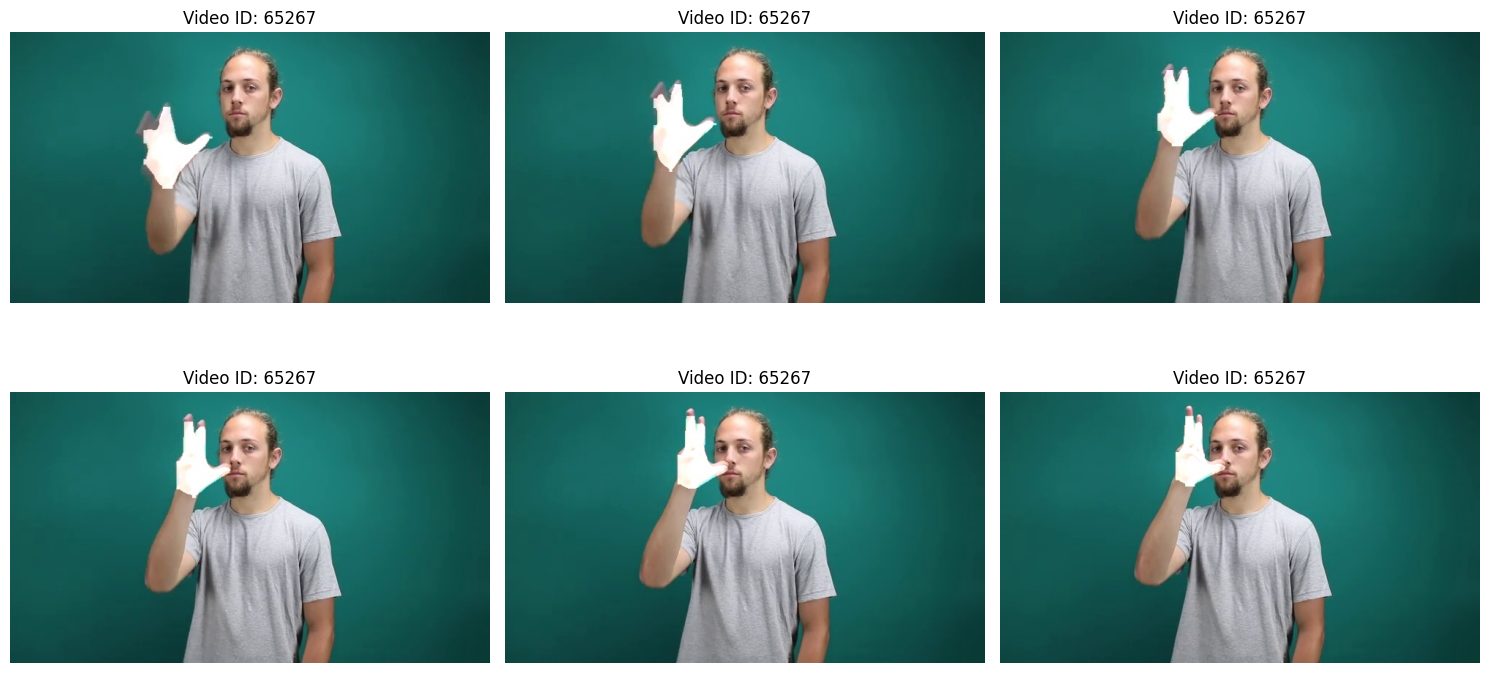

In [4]:
# -------- CONFIGURATION --------
segmented_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\segmented_wlasl"
max_examples = 6  

# -------- LOAD & FILTER GOOD EXAMPLES --------
all_video_ids = os.listdir(segmented_root)
shuffle(all_video_ids)  # Shuffle for randomness

good_samples = []

for video_id in all_video_ids:
    video_folder = os.path.join(segmented_root, video_id)
    frame_files = sorted([f for f in os.listdir(video_folder) if f.endswith("_mask.jpg")])

    for mask_file in frame_files:
        json_file = mask_file.replace("_mask.jpg", ".json")
        json_path = os.path.join(video_folder, json_file)

        # Skip if corresponding JSON doesn't exist
        if not os.path.exists(json_path):
            continue

        # Load detection metadata
        with open(json_path, "r") as f:
            data = json.load(f)
            detections = data.get("detections", [])

        # Only consider if at least one hand detected
        if len(detections) > 0:
            mask_img_path = os.path.join(video_folder, mask_file)
            good_samples.append((video_id, mask_img_path))

        if len(good_samples) >= max_examples:
            break
    if len(good_samples) >= max_examples:
        break

# -------- VISUALIZE GOOD EXAMPLES --------
plt.figure(figsize=(15, 8))
for i, (video_id, img_path) in enumerate(good_samples):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Video ID: {video_id}")
    plt.axis('off')

plt.tight_layout()
plt.show()


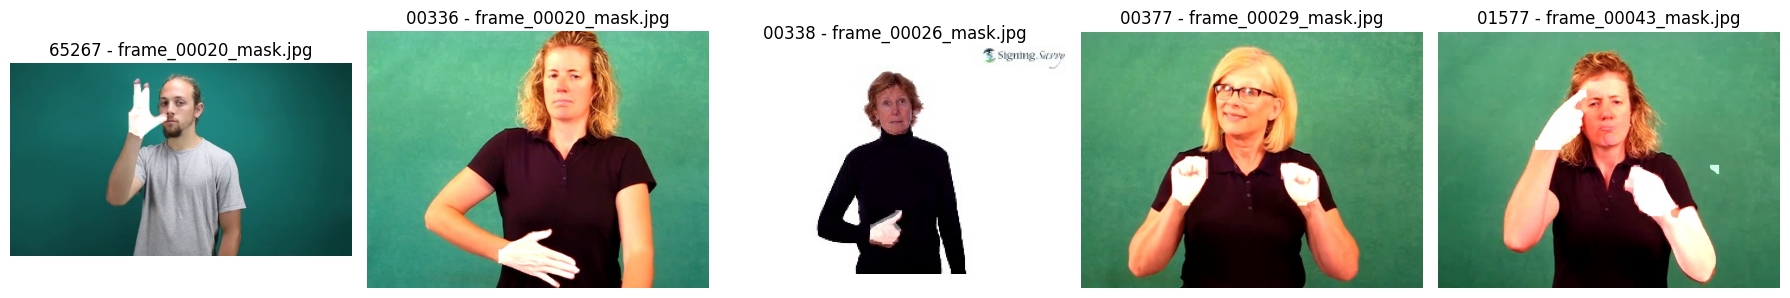

In [8]:
# -------- MANUALLY SPECIFIED SAMPLES --------
samples = [
    ("65267", "frame_00020_mask.jpg"),
    ("00336", "frame_00020_mask.jpg"),
    ("00338", "frame_00026_mask.jpg"),
    ("00377", "frame_00029_mask.jpg"),
    ("01577", "frame_00043_mask.jpg"),
]

# -------- VISUALIZATION --------
plt.figure(figsize=(18, 8))

for i, (video_id, frame_file) in enumerate(samples):
    img_path = os.path.join(segmented_root, video_id, frame_file)
    
    if not os.path.exists(img_path):
        print(f"Missing: {img_path}")
        continue

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"{video_id} - {frame_file}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# WLASL classification using RESNET-18

In [ ]:
import os
import cv2
import json
import glob
import shutil
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from collections import Counter, defaultdict
from concurrent.futures import ProcessPoolExecutor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# A Sample of 50 dataset classes is created. 

In [6]:
# === INPUT PATHS ===
root_folder = Path(r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\segmented_wlasl")
mapping_csv = Path(r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\gloss_mapping.csv")
output_folder = Path(r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl")

# === Updated Target Gloss Labels ===
target_glosses = set([
    "action", "alligator", "alone", "amputate", "angel", "benefit", "bird", "bracelet",
    "candy", "chapter", "cheese", "contact", "crazy", "cute", "december", "desert", "drama", "drive",
    "fear", "festival", "her", "high school", "highway", "inform", "listen", "mosquito", "open", 
    "opposite", "paper", "pregnant", "relax", "remove", "ring", "schedule", "sculpture", "shock", 
    "shovel", "speech", "thank you", "tomorrow", "willing",
    "this", "book", "heavy", "my", "myself", "abdomen", "hurt", "hello", "goodbye"
])

# === STEP 1: Load and filter the mapping ===
df = pd.read_csv(mapping_csv)
df['video_id'] = df['video_id'].astype(str).str.zfill(5)
filtered_df = df[df['gloss'].isin(target_glosses)]

# === STEP 2: Create folders for each gloss label ===
for gloss in target_glosses:
    class_folder = output_folder / gloss
    class_folder.mkdir(parents=True, exist_ok=True)

# === STEP 3: Copy image + JSON files ===
for _, row in filtered_df.iterrows():
    video_id = row['video_id']
    gloss = row['gloss']
    
    src_dir = root_folder / video_id
    dest_dir = output_folder / gloss
    
    if not src_dir.exists():
        print(f"[WARNING] Folder missing: {src_dir}")
        continue
    
    for file_name in os.listdir(src_dir):
        src_path = src_dir / file_name
        # Add folder name prefix to avoid file name collisions
        new_file_name = f"{video_id}_{file_name}"
        dest_path = dest_dir / new_file_name
        shutil.copy2(src_path, dest_path)

print("Sample dataset 'custom_wlasl' created successfully!")


Sample dataset 'custom_wlasl' created successfully!


# Validating the results of trained YOLO segmentation model to see if each image has its corresponding .json file with the bounding box and masking information and coordinates?

In [7]:
# Dataset path
data_dir = Path(r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl")

results = []

for class_folder in sorted(data_dir.iterdir()):
    if not class_folder.is_dir():
        continue

    image_files = list(class_folder.glob("*_mask.jpg"))
    json_files = list(class_folder.glob("*.json"))

    # Normalize stem by removing "_mask" from image files
    image_stems = set(f.stem.replace("_mask", "") for f in image_files)
    json_stems = set(f.stem for f in json_files)

    matched = len(image_stems & json_stems)
    missing_jsons = len(image_stems - json_stems)
    missing_images = len(json_stems - image_stems)

    results.append({
        "Class": class_folder.name,
        "Total Images (_mask.jpg)": len(image_stems),
        "Total JSONs": len(json_stems),
        "Matched Pairs": matched,
        "Missing JSONs": missing_jsons,
        "Missing Images": missing_images
    })

# Create and display summary
df_summary = pd.DataFrame(results)
df_summary = df_summary.sort_values(by="Matched Pairs", ascending=False)
df_summary


Class  Total Images (_mask.jpg)  Total JSONs  Matched Pairs  \
11      chapter                       303          303            303   
18        drama                       298          298            298   
41     schedule                       292          292            292   
6       benefit                       288          288            288   
30       listen                       281          281            281   
20         fear                       275          275            275   
1        action                       265          265            265   
49      willing                       257          257            257   
4      amputate                       253          253            253   
34         open                       247          247            247   
21     festival                       247          247            247   
2     alligator                       246          246            246   
37     pregnant                       243          243            243   
13      contact                       243          243            243   
31     mosquito                       242          242            242   
14        crazy                       237          237            237   
39       remove                       237          237            237   
9      bracelet                       235          235            235   
35     opposite                       235          235            235   
48     tomorrow                       231          231            231   
16     december                       229          229            229   
42    sculpture                       229          229            229   
12       cheese                       226          226            226   
38        relax                       225          225            225   
46    thank you                       224          224            224   
24        hello                       219          219            219   
45       speech                       217          217            217   
32           my                       215          215            215   
26  high school                       211          211            211   
22      goodbye                       210          210            210   
23        heavy                       208          208            208   
17       desert                       207          207            207   
5         angel                       205          205            205   
44       shovel                       202          202            202   
10        candy                       202          202            202   
40         ring                       199          199            199   
0       abdomen                       194          194            194   
33       myself                       192          192            192   
28         hurt                       188          188            188   
36        paper                       183          183            183   
19        drive                       179          179            179   
8          book                       173          173            173   
27      highway                       155          155            155   
47         this                       155          155            155   
15         cute                       147          147            147   
29       inform                       142          142            142   
43        shock                       140          140            140   
7          bird                       139          139            139   
3         alone                       138          138            138   
25          her                       138          138            138   

    Missing JSONs  Missing Images  
11              0               0  
18              0               0  
41              0               0  
6               0               0  
30              0               0  
20              0               0  
1               0               0 

In [9]:
def verify_wlasl_dataset(root_dir):
    """
    Verify that each subfolder in the WLASL dataset has matching image and JSON file pairs.
    
    Args:
        root_dir (str): Path to the custom_wlasl directory
    """
    # Get all subfolders (class labels)
    class_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    
    print(f"Found {len(class_folders)} class folders")
    
    results = {
        "folders_checked": 0,
        "folders_with_mismatches": [],
        "total_image_files": 0,
        "total_json_files": 0,
        "total_matched_pairs": 0,
        "mismatched_files": defaultdict(list)
    }
    
    for class_folder in class_folders:
        folder_path = os.path.join(root_dir, class_folder)
        
        # Get all files in the folder
        all_files = os.listdir(folder_path)
        
        # Separate image files and JSON files
        # Based on naming convention in screenshot: XXXXX_frame_YYYYY and XXXXX_frame_YYYYY_mask
        image_files = [f for f in all_files if f.endswith('.jpg') or f.endswith('.png')]
        json_files = [f for f in all_files if f.endswith('.json')]
        
        # Count files
        results["folders_checked"] += 1
        results["total_image_files"] += len(image_files)
        results["total_json_files"] += len(json_files)
        
        # Get base names for matching
        image_base_names = set()
        for img in image_files:
            # Handle both regular frames and mask frames
            if '_mask' in img:
                base = os.path.splitext(img)[0].replace('_mask', '')
            else:
                base = os.path.splitext(img)[0]
            image_base_names.add(base)
        
        json_base_names = set()
        for js in json_files:
            base = os.path.splitext(js)[0]
            json_base_names.add(base)
        
        # Find matches and mismatches
        matched_pairs = image_base_names.intersection(json_base_names)
        results["total_matched_pairs"] += len(matched_pairs)
        
        images_without_json = image_base_names - json_base_names
        jsons_without_image = json_base_names - image_base_names
        
        if images_without_json or jsons_without_image:
            results["folders_with_mismatches"].append(class_folder)
            
            if images_without_json:
                results["mismatched_files"][class_folder].append(f"Images without JSON: {len(images_without_json)}")
                # List up to 5 examples
                examples = list(images_without_json)[:5]
                results["mismatched_files"][class_folder].append(f"Examples: {examples}")
            
            if jsons_without_image:
                results["mismatched_files"][class_folder].append(f"JSONs without image: {len(jsons_without_image)}")
                # List up to 5 examples
                examples = list(jsons_without_image)[:5]
                results["mismatched_files"][class_folder].append(f"Examples: {examples}")
    
    # Print summary
    print("\n=== SUMMARY ===")
    print(f"Total folders checked: {results['folders_checked']}")
    print(f"Total image files: {results['total_image_files']}")
    print(f"Total JSON files: {results['total_json_files']}")
    print(f"Total matched pairs: {results['total_matched_pairs']}")
    print(f"Folders with mismatches: {len(results['folders_with_mismatches'])}")
    
    # Print details of mismatches
    if results["folders_with_mismatches"]:
        print("\n=== MISMATCH DETAILS ===")
        for folder, issues in results["mismatched_files"].items():
            print(f"\nFolder: {folder}")
            for issue in issues:
                print(f"  {issue}")
    
    return results

# Usage
if __name__ == "__main__":
    # Using the provided path to your custom_wlasl directory
    dataset_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl"
    results = verify_wlasl_dataset(dataset_path)

Found 50 class folders

=== SUMMARY ===
Total folders checked: 50
Total image files: 10846
Total JSON files: 10846
Total matched pairs: 10846
Folders with mismatches: 0


# creating splits train, val, test (80: 10 :10)

In [11]:
# Configuration
SOURCE_DIR = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl"
DEST_ROOT = os.path.join(os.path.dirname(SOURCE_DIR), "custom_wlasl_split")

# Create output directories
TRAIN_DIR = os.path.join(DEST_ROOT, "train")
VAL_DIR = os.path.join(DEST_ROOT, "val")
TEST_DIR = os.path.join(DEST_ROOT, "test")

# Create the split directories
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(split_dir, exist_ok=True)

# Split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def main():
    # Set random seed for reproducibility
    random.seed(42)
    
    # Stats tracking
    stats = {
        "classes": 0,
        "train_files": 0,
        "val_files": 0,
        "test_files": 0
    }
    
    # First, analyze the dataset to find minimum class size
    class_folders = [f for f in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, f))]
    class_sizes = {}
    
    print("Analyzing dataset class sizes...")
    for class_name in class_folders:
        class_path = os.path.join(SOURCE_DIR, class_name)
        # Find all mask images
        images = [f for f in os.listdir(class_path) if f.endswith("_mask.jpg") or f.endswith("_mask.png")]
        class_sizes[class_name] = len(images)
    
    # Calculate balanced training set size
    min_class_size = min(class_sizes.values())
    balanced_train_size = int(min_class_size * TRAIN_RATIO)
    
    print(f"Minimum class size: {min_class_size} images")
    print(f"Balanced training set will have {balanced_train_size} images per class")
    
    # Process each class folder
    for class_name in tqdm(class_folders, desc="Processing classes"):
        stats["classes"] += 1
        class_path = os.path.join(SOURCE_DIR, class_name)
        
        # Find all mask images
        all_images = [f for f in os.listdir(class_path) if f.endswith("_mask.jpg") or f.endswith("_mask.png")]
        
        # Shuffle with fixed seed for reproducibility
        random.shuffle(all_images)
        
        # For the training set, take exactly balanced_train_size
        train_images = all_images[:balanced_train_size]
        
        # Remaining images split between val and test
        remaining = all_images[balanced_train_size:]
        val_size = int(len(remaining) * (VAL_RATIO / (VAL_RATIO + TEST_RATIO)))
        
        val_images = remaining[:val_size]
        test_images = remaining[val_size:]
        
        # Update stats
        stats["train_files"] += len(train_images)
        stats["val_files"] += len(val_images)
        stats["test_files"] += len(test_images)
        
        # Copy files to respective directories
        copy_files(train_images, class_path, class_name, TRAIN_DIR)
        copy_files(val_images, class_path, class_name, VAL_DIR)
        copy_files(test_images, class_path, class_name, TEST_DIR)
    
    # Print summary
    print("\n=== Dataset Split Complete ===")
    print(f"Source directory: {SOURCE_DIR}")
    print(f"Destination directory: {DEST_ROOT}")
    print(f"Classes processed: {stats['classes']}")
    print(f"Train set: {stats['train_files']} files ({stats['train_files']/stats['classes']} per class)")
    print(f"Validation set: {stats['val_files']} files")
    print(f"Test set: {stats['test_files']} files")
    print(f"Total: {stats['train_files'] + stats['val_files'] + stats['test_files']} files")
    
    # Calculate class distribution
    train_class_distribution = get_class_distribution(TRAIN_DIR)
    print("\nTraining set class distribution:")
    for class_name, count in train_class_distribution.items():
        print(f"  {class_name}: {count} images")

def copy_files(file_list, source_path, class_name, target_root):
    """Copy image files and their corresponding JSON files to the target directory"""
    
    # Create the class directory in the target
    target_class_dir = os.path.join(target_root, class_name)
    os.makedirs(target_class_dir, exist_ok=True)
    
    for img_name in file_list:
        # Copy the image file
        src_img = os.path.join(source_path, img_name)
        dst_img = os.path.join(target_class_dir, img_name)
        shutil.copy2(src_img, dst_img)
        
        # Copy the corresponding JSON file
        json_name = img_name.replace("_mask.jpg", ".json").replace("_mask.png", ".json")
        src_json = os.path.join(source_path, json_name)
        
        if os.path.exists(src_json):
            dst_json = os.path.join(target_class_dir, json_name)
            shutil.copy2(src_json, dst_json)
            
        # Also copy the corresponding frame image if it exists
        frame_name = img_name.replace("_mask.jpg", ".jpg").replace("_mask.png", ".png")
        src_frame = os.path.join(source_path, frame_name)
        
        if os.path.exists(src_frame):
            dst_frame = os.path.join(target_class_dir, frame_name)
            shutil.copy2(src_frame, dst_frame)

def get_class_distribution(directory):
    """Count the number of files per class in a directory"""
    distribution = {}
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count only mask images
            count = len([f for f in os.listdir(class_path) if f.endswith("_mask.jpg") or f.endswith("_mask.png")])
            distribution[class_name] = count
            
    return distribution

if __name__ == "__main__":
    main()

Analyzing dataset class sizes...
Minimum class size: 138 images
Balanced training set will have 110 images per class


Processing classes: 100%|██████████████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.87s/it]


=== Dataset Split Complete ===
Source directory: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl
Destination directory: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_split
Classes processed: 50
Train set: 5500 files (110.0 per class)
Validation set: 2657 files
Test set: 2689 files
Total: 10846 files

Training set class distribution:
  abdomen: 110 images
  action: 110 images
  alligator: 110 images
  alone: 110 images
  amputate: 110 images
  angel: 110 images
  benefit: 110 images
  bird: 110 images
  book: 110 images
  bracelet: 110 images
  candy: 110 images
  chapter: 110 images
  cheese: 110 images
  contact: 110 images
  crazy: 110 images
  cute: 110 images
  december: 110 images
  desert: 110 images
  drama: 110 images
  drive: 110 images
  fear: 110 images
  festival: 110 images
  goodbye: 110 images
  heavy: 110 images
  hello: 110 images
  her: 110 images
  high school

# apply bounding box overlay on 50 class dataset using the .json files created from the trained YOLO segmentation model.

In [12]:
# === CONFIGURATION ===
input_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_split"
output_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_overlay_split"

# === FUNCTION TO DRAW MERGED BOUNDING BOX ===
def overlay_bbox(image_path, json_path, output_path):
    try:
        img = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        with open(json_path, 'r') as f:
            data = json.load(f)

        if "detections" in data:
            all_boxes = []

            for detection in data["detections"]:
                if "bbox" in detection:
                    all_boxes.append(detection["bbox"])

            if all_boxes:
                # Merge bounding boxes: compute the min/max over all
                x1 = min(box[0] for box in all_boxes)
                y1 = min(box[1] for box in all_boxes)
                x2 = max(box[2] for box in all_boxes)
                y2 = max(box[3] for box in all_boxes)
                merged_box = (x1, y1, x2, y2)
                draw.rectangle(merged_box, outline="red", width=3)

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        img.save(output_path)

    except Exception as e:
        print(f"[ERROR] Skipping {image_path}: {e}")

# === PROCESS ALL SPLITS ===
splits = ["train", "val", "test"]  # Added "val" to the splits
total_processed = 0
total_skipped = 0

for split in splits:
    split_dir = os.path.join(input_root, split)
    output_split_dir = os.path.join(output_root, split)
    
    # Skip if the split directory doesn't exist
    if not os.path.exists(split_dir):
        print(f"Split directory {split_dir} not found. Skipping.")
        continue
    
    print(f"\nProcessing {split} split...")
    class_names = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    
    for class_name in tqdm(class_names, desc=f"Processing {split} classes"):
        class_dir = os.path.join(split_dir, class_name)
        output_class_dir = os.path.join(output_split_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        # Get all image files in the class directory
        files = os.listdir(class_dir)
        image_files = [f for f in files if f.endswith("_mask.jpg") or f.endswith("_mask.png")]
        
        for img_file in image_files:
            image_path = os.path.join(class_dir, img_file)
            
            # Handle both jpg and png file extensions
            if img_file.endswith("_mask.jpg"):
                json_name = img_file.replace("_mask.jpg", ".json")
            else:
                json_name = img_file.replace("_mask.png", ".json")
                
            json_path = os.path.join(class_dir, json_name)
            output_path = os.path.join(output_class_dir, img_file)
            
            if os.path.exists(json_path):
                overlay_bbox(image_path, json_path, output_path)
                total_processed += 1
            else:
                total_skipped += 1
                print(f"Missing JSON file for {image_path}")

# === SUMMARY ===
print("\n=== Bounding Box Overlay Complete ===")
print(f"Total Processed: {total_processed}")
print(f"Skipped due to missing/invalid JSONs: {total_skipped}")
print(f"Overlay output saved to: {output_root}")


Processing train split...


Processing train classes: 100%|████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]



Processing val split...


Processing val classes: 100%|██████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]



Processing test split...


Processing test classes: 100%|█████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


=== Bounding Box Overlay Complete ===
Total Processed: 10846
Skipped due to missing/invalid JSONs: 0
Overlay output saved to: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_overlay_split


# Filter out any images with bounding boxes that cover more than 60%. Also filter out images with no bounding boxes (if FILTER_NO_BBOX is True)

In [13]:
# === CONFIGURATION ===
input_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_overlay_split"
output_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_filtered"

# Threshold for filtering (percentage of image covered by bounding box)
AREA_THRESHOLD = 0.60  # 60% - filter out if bbox covers more than this
# Flag to decide whether to filter out images with no bounding boxes
FILTER_NO_BBOX = True  # Set to False if you want to keep images without bounding boxes

def filter_images():
    # Process all splits
    splits = ["train", "val", "test"]
    stats = {
        "total_images": 0,
        "filtered_large_bbox": 0,
        "filtered_no_bbox": 0,
        "kept_images": 0
    }
    
    for split in splits:
        split_dir = os.path.join(input_root, split)
        output_split_dir = os.path.join(output_root, split)
        
        if not os.path.exists(split_dir):
            print(f"Split directory {split_dir} not found. Skipping.")
            continue
        
        print(f"\nProcessing {split} split...")
        class_names = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        
        for class_name in tqdm(class_names, desc=f"Processing {split} classes"):
            class_dir = os.path.join(split_dir, class_name)
            output_class_dir = os.path.join(output_split_dir, class_name)
            os.makedirs(output_class_dir, exist_ok=True)
            
            # Get all image files in the class directory
            files = os.listdir(class_dir)
            image_files = [f for f in files if f.endswith("_mask.jpg") or f.endswith("_mask.png")]
            
            for img_file in image_files:
                image_path = os.path.join(class_dir, img_file)
                
                # Find corresponding JSON file
                if img_file.endswith("_mask.jpg"):
                    json_name = img_file.replace("_mask.jpg", ".json")
                else:
                    json_name = img_file.replace("_mask.png", ".json")
                    
                json_path = os.path.join(class_dir.replace("overlay_split", "split"), json_name)
                
                stats["total_images"] += 1
                should_keep = True
                
                # Check if JSON exists and read bounding box
                if os.path.exists(json_path):
                    try:
                        # Get image dimensions
                        with Image.open(image_path) as img:
                            img_width, img_height = img.size
                            img_area = img_width * img_height
                        
                        # Get bounding box dimensions from JSON
                        with open(json_path, 'r') as f:
                            data = json.load(f)
                        
                        has_bbox = False
                        if "detections" in data and data["detections"]:
                            all_boxes = []
                            for detection in data["detections"]:
                                if "bbox" in detection:
                                    all_boxes.append(detection["bbox"])
                                    has_bbox = True
                            
                            if all_boxes:
                                # Merge bounding boxes
                                x1 = min(box[0] for box in all_boxes)
                                y1 = min(box[1] for box in all_boxes)
                                x2 = max(box[2] for box in all_boxes)
                                y2 = max(box[3] for box in all_boxes)
                                
                                # Calculate bounding box area
                                bbox_width = x2 - x1
                                bbox_height = y2 - y1
                                bbox_area = bbox_width * bbox_height
                                
                                # Calculate coverage ratio
                                coverage_ratio = bbox_area / img_area
                                
                                # Check if bounding box is too large (more than 60%)
                                if coverage_ratio > AREA_THRESHOLD:
                                    stats["filtered_large_bbox"] += 1
                                    should_keep = False
                        
                        # Check if there's no bounding box at all
                        elif FILTER_NO_BBOX and not has_bbox:
                            stats["filtered_no_bbox"] += 1
                            should_keep = False
                        
                        # If we should keep the image, copy it to the output directory
                        if should_keep:
                            stats["kept_images"] += 1
                            output_path = os.path.join(output_class_dir, img_file)
                            os.makedirs(os.path.dirname(output_path), exist_ok=True)
                            Image.open(image_path).save(output_path)
                        
                    except Exception as e:
                        print(f"[ERROR] Processing {image_path}: {e}")
    
    # Print summary
    print("\n=== Filtering Complete ===")
    print(f"Total images processed: {stats['total_images']}")
    print(f"Images filtered out (bbox too large > {AREA_THRESHOLD*100}%): {stats['filtered_large_bbox']} ({stats['filtered_large_bbox']/stats['total_images']*100:.2f}%)")
    
    if FILTER_NO_BBOX:
        print(f"Images filtered out (no bbox): {stats['filtered_no_bbox']} ({stats['filtered_no_bbox']/stats['total_images']*100:.2f}%)")
    
    print(f"Images kept: {stats['kept_images']} ({stats['kept_images']/stats['total_images']*100:.2f}%)")
    print(f"Filtered dataset saved to: {output_root}")

if __name__ == "__main__":
    filter_images()


Processing train split...


Processing train classes: 100%|████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.36it/s]



Processing val split...


Processing val classes: 100%|██████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]



Processing test split...


Processing test classes: 100%|█████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.00it/s]


=== Filtering Complete ===
Total images processed: 10846
Images filtered out (bbox too large > 60.0%): 1964 (18.11%)
Images filtered out (no bbox): 4011 (36.98%)
Images kept: 4871 (44.91%)
Filtered dataset saved to: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_filtered


# preprocessing train, validate, test images to make them ready for RESNET 18

In [14]:
# Configuration
input_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_filtered"
output_root = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_preprocessed"

# Parameters for preprocessing
target_size = (224, 224)  # ResNet input size
normalize = True  # Whether to normalize the images

# ImageNet mean and std for normalization (if using PyTorch's transforms later, this step can be skipped)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def preprocess_image(src_path, dst_path):
    """Preprocess a single image"""
    try:
        # Read image with PIL (better color handling)
        img = Image.open(src_path).convert('RGB')
        
        # Resize to target size
        img = img.resize(target_size, Image.LANCZOS)
        
        if normalize:
            # Convert to numpy array for normalization
            img_array = np.array(img).astype(np.float32) / 255.0
            
            # Normalize using ImageNet mean and std
            img_array = (img_array - mean) / std
            
            # Convert back to 0-255 range for saving
            img_array = np.clip(img_array * std + mean, 0, 1) * 255
            img_array = img_array.astype(np.uint8)
            
            # Convert back to PIL
            img = Image.fromarray(img_array)
        
        # Save the preprocessed image
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        img.save(dst_path, quality=95)
        return True
    except Exception as e:
        print(f"Error processing {src_path}: {e}")
        return False

def process_class_folder(split, class_name):
    """Process all images in a class folder"""
    src_class_dir = os.path.join(input_root, split, class_name)
    dst_class_dir = os.path.join(output_root, split, class_name)
    
    os.makedirs(dst_class_dir, exist_ok=True)
    processed = 0
    skipped = 0
    
    # Get all mask images
    image_files = [f for f in os.listdir(src_class_dir) if f.endswith("_mask.jpg") or f.endswith("_mask.png")]
    
    for img_file in image_files:
        src_path = os.path.join(src_class_dir, img_file)
        dst_path = os.path.join(dst_class_dir, img_file)
        
        success = preprocess_image(src_path, dst_path)
        if success:
            processed += 1
        else:
            skipped += 1
    
    return {
        'split': split,
        'class': class_name,
        'processed': processed,
        'skipped': skipped
    }

def main():
    # Create output directory
    os.makedirs(output_root, exist_ok=True)
    
    splits = ['train', 'val', 'test']
    all_tasks = []
    
    # Gather all preprocessing tasks
    for split in splits:
        split_dir = os.path.join(input_root, split)
        
        if not os.path.exists(split_dir):
            print(f"Split directory {split_dir} not found. Skipping.")
            continue
        
        class_names = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        
        for class_name in class_names:
            all_tasks.append((split, class_name))
    
    # Process tasks with progress bar
    results = []
    total_processed = 0
    total_skipped = 0
    
    with tqdm(total=len(all_tasks), desc="Preprocessing classes") as pbar:
        for split, class_name in all_tasks:
            result = process_class_folder(split, class_name)
            results.append(result)
            
            total_processed += result['processed']
            total_skipped += result['skipped']
            
            pbar.update(1)
    
    # Print summary
    print("\n=== Preprocessing Complete ===")
    print(f"Total images processed: {total_processed}")
    print(f"Images skipped due to errors: {total_skipped}")
    print(f"Preprocessed dataset saved to: {output_root}")
    
    # Print stats per split
    for split in splits:
        split_results = [r for r in results if r['split'] == split]
        split_processed = sum(r['processed'] for r in split_results)
        split_classes = len(split_results)
        
        print(f"\n{split.upper()} split:")
        print(f"  Classes: {split_classes}")
        print(f"  Images: {split_processed}")

if __name__ == "__main__":
    main()

Preprocessing classes: 100%|█████████████████████████████████████████████████████████| 150/150 [01:27<00:00,  1.71it/s]


=== Preprocessing Complete ===
Total images processed: 4723
Images skipped due to errors: 0
Preprocessed dataset saved to: C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_preprocessed

TRAIN split:
  Classes: 50
  Images: 2354

VAL split:
  Classes: 50
  Images: 1173

TEST split:
  Classes: 50
  Images: 1196


# training 

In [1]:
# Dataset path
train_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_preprocessed\train"

# Get class names (folder names)
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Create class to idx mapping
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

# Custom Dataset class
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        
        # Get all image paths and labels
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            class_idx = class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith("_mask.jpg") or img_name.endswith("_mask.png"):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Load image and convert to tensor
        image = Image.open(img_path).convert('RGB')
        # Convert to tensor manually
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        image = image.transpose(2, 0, 1)  # Convert HWC to CHW format
        image = torch.FloatTensor(image)
        
        return image, label

# Create dataset
train_dataset = SignLanguageDataset(train_dir)
print(f"Training samples: {len(train_dataset)}")

# Create data loader with smaller batch size and no workers
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Load ResNet-18 model with updated parameters
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers of ResNet-18
# Freeze all layers except the last 2 layers
print("Freezing early layers of ResNet-18...")
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Modify the final fully connected layer with dropout
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout with 0.5 probability
    nn.Linear(num_ftrs, num_classes)
)

# Move model to device
model = model.to(device)

# Define loss function and optimizer with very small learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000002)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='best_resnet_wlasl.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path
        
    def __call__(self, train_loss, model):
        if train_loss < self.best_loss - self.min_delta:
            self.best_loss = train_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            
    def save_checkpoint(self, model):
        print(f'Training loss decreased. Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3, path='best_resnet_wlasl.pth')
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        # Iterate over training data
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # Print batch progress
            if (i+1) % 10 == 0:
                print(f'  Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Update history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        # Early stopping check
        early_stopping(epoch_loss, model)
        
        # Check if early stopping triggered
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        print()
    
    return model, history

# Train the model
print("Starting training...")
model, history = train_model(model, train_loader, criterion, optimizer, num_epochs=50)

# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': class_to_idx,
    'num_classes': num_classes,
    'history': history
}, 'final_resnet_wlasl.pth')

print("Training complete!")
print(f"Best model saved as: best_resnet_wlasl.pth")
print(f"Final model saved as: final_resnet_wlasl.pth")

Using device: cuda:0
Number of classes: 50
Training samples: 2354
Freezing early layers of ResNet-18...
Starting training...
Epoch 1/50
----------
  Batch 10/148, Loss: 4.0795
  Batch 20/148, Loss: 4.3449
  Batch 30/148, Loss: 4.5309
  Batch 40/148, Loss: 3.9342
  Batch 50/148, Loss: 4.2153
  Batch 60/148, Loss: 4.5959
  Batch 70/148, Loss: 4.3330
  Batch 80/148, Loss: 4.2797
  Batch 90/148, Loss: 3.9832
  Batch 100/148, Loss: 4.2026
  Batch 110/148, Loss: 4.1516
  Batch 120/148, Loss: 4.0271
  Batch 130/148, Loss: 4.3188
  Batch 140/148, Loss: 3.8636
Train Loss: 4.1522 Acc: 0.0229
Training loss decreased. Saving model to best_resnet_wlasl.pth

Epoch 2/50
----------
  Batch 10/148, Loss: 4.1825
  Batch 20/148, Loss: 3.9908
  Batch 30/148, Loss: 3.8292
  Batch 40/148, Loss: 3.7176
  Batch 50/148, Loss: 3.5517
  Batch 60/148, Loss: 3.9219
  Batch 70/148, Loss: 3.9409
  Batch 80/148, Loss: 4.0034
  Batch 90/148, Loss: 3.9543
  Batch 100/148, Loss: 4.0990
  Batch 110/148, Loss: 3.9046
  Ba

# validation 

Using device: cuda:0
Validation samples: 1173
Evaluating model on validation data...
Validation Accuracy: 89.00%

Classification Report:
              precision    recall  f1-score   support

     abdomen     1.0000    1.0000    1.0000        28
      action     0.9706    0.8462    0.9041        39
   alligator     1.0000    0.9630    0.9811        27
       alone     1.0000    1.0000    1.0000         3
    amputate     0.9565    0.8800    0.9167        25
       angel     1.0000    0.5000    0.6667         8
     benefit     1.0000    0.8889    0.9412        36
        bird     1.0000    0.6000    0.7500         5
        book     0.7895    0.9375    0.8571        16
    bracelet     0.8333    0.7895    0.8108        19
       candy     0.7647    0.7647    0.7647        17
     chapter     1.0000    0.9841    0.9920        63
      cheese     0.9375    0.5000    0.6522        30
     contact     1.0000    0.0811    0.1500        37
       crazy     0.7407    1.0000    0.8511        2

C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

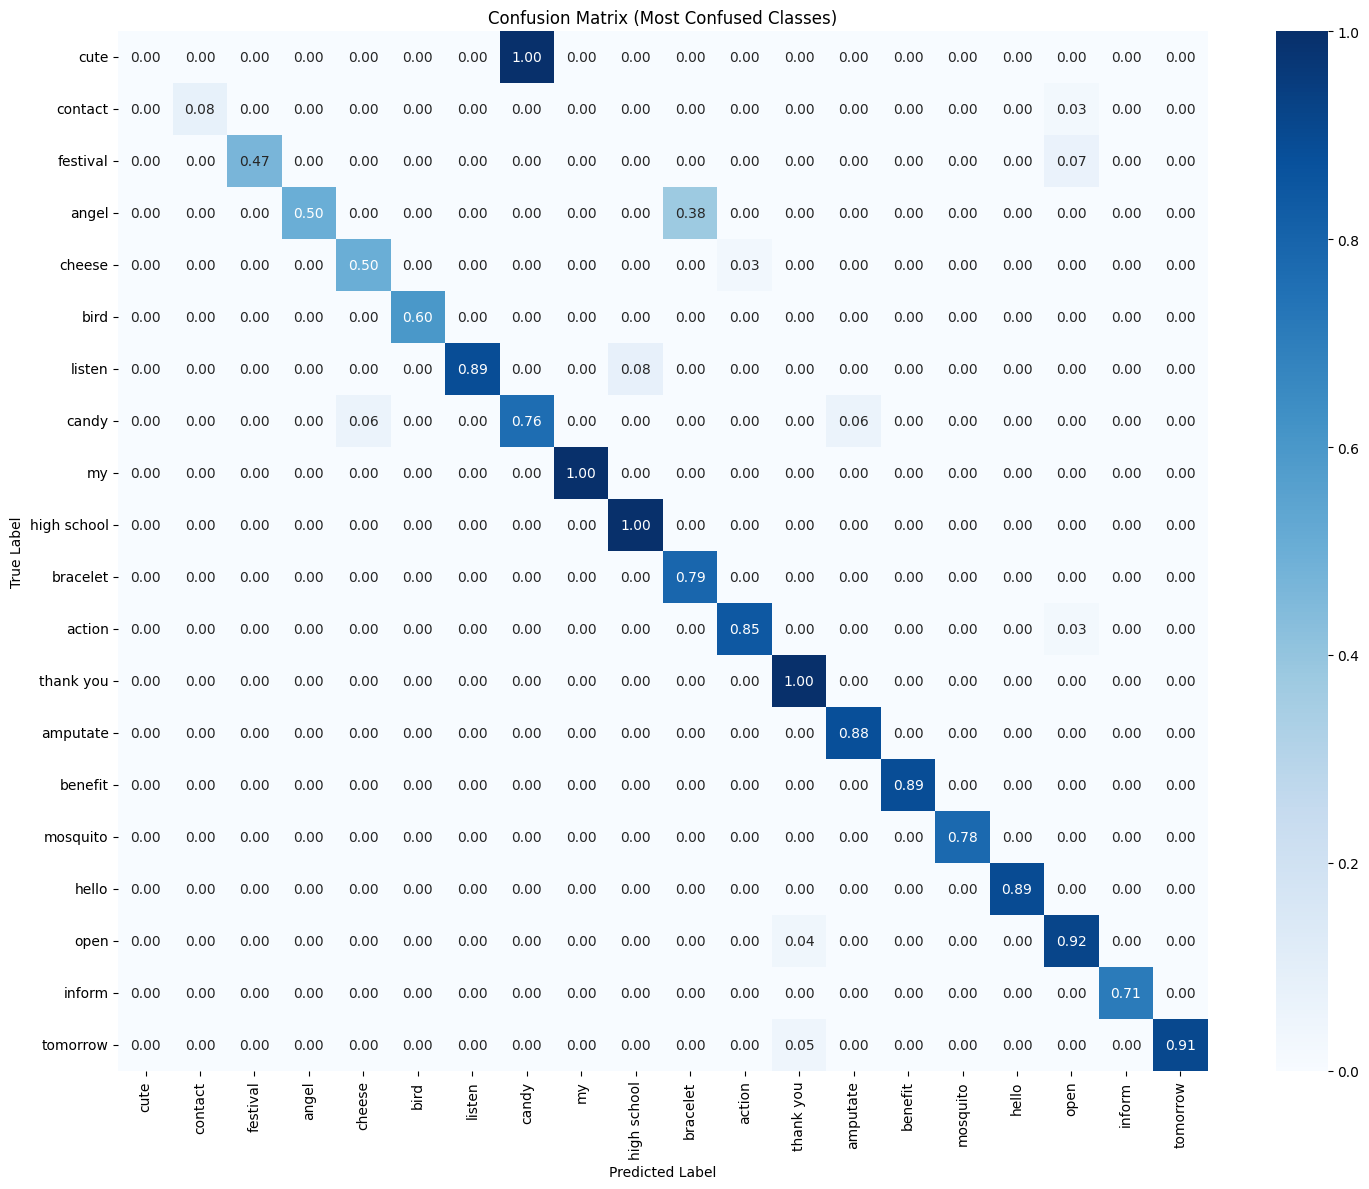

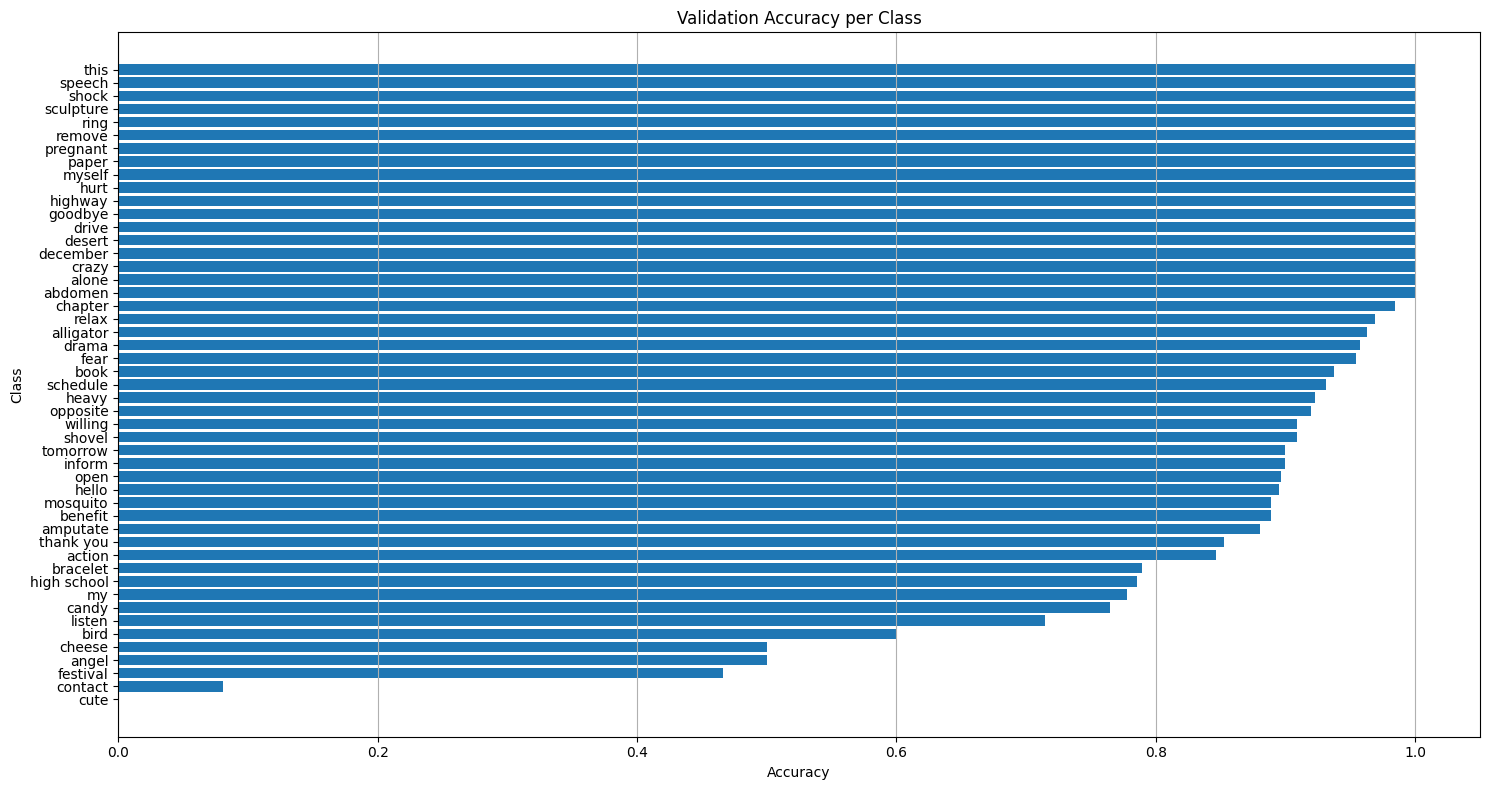

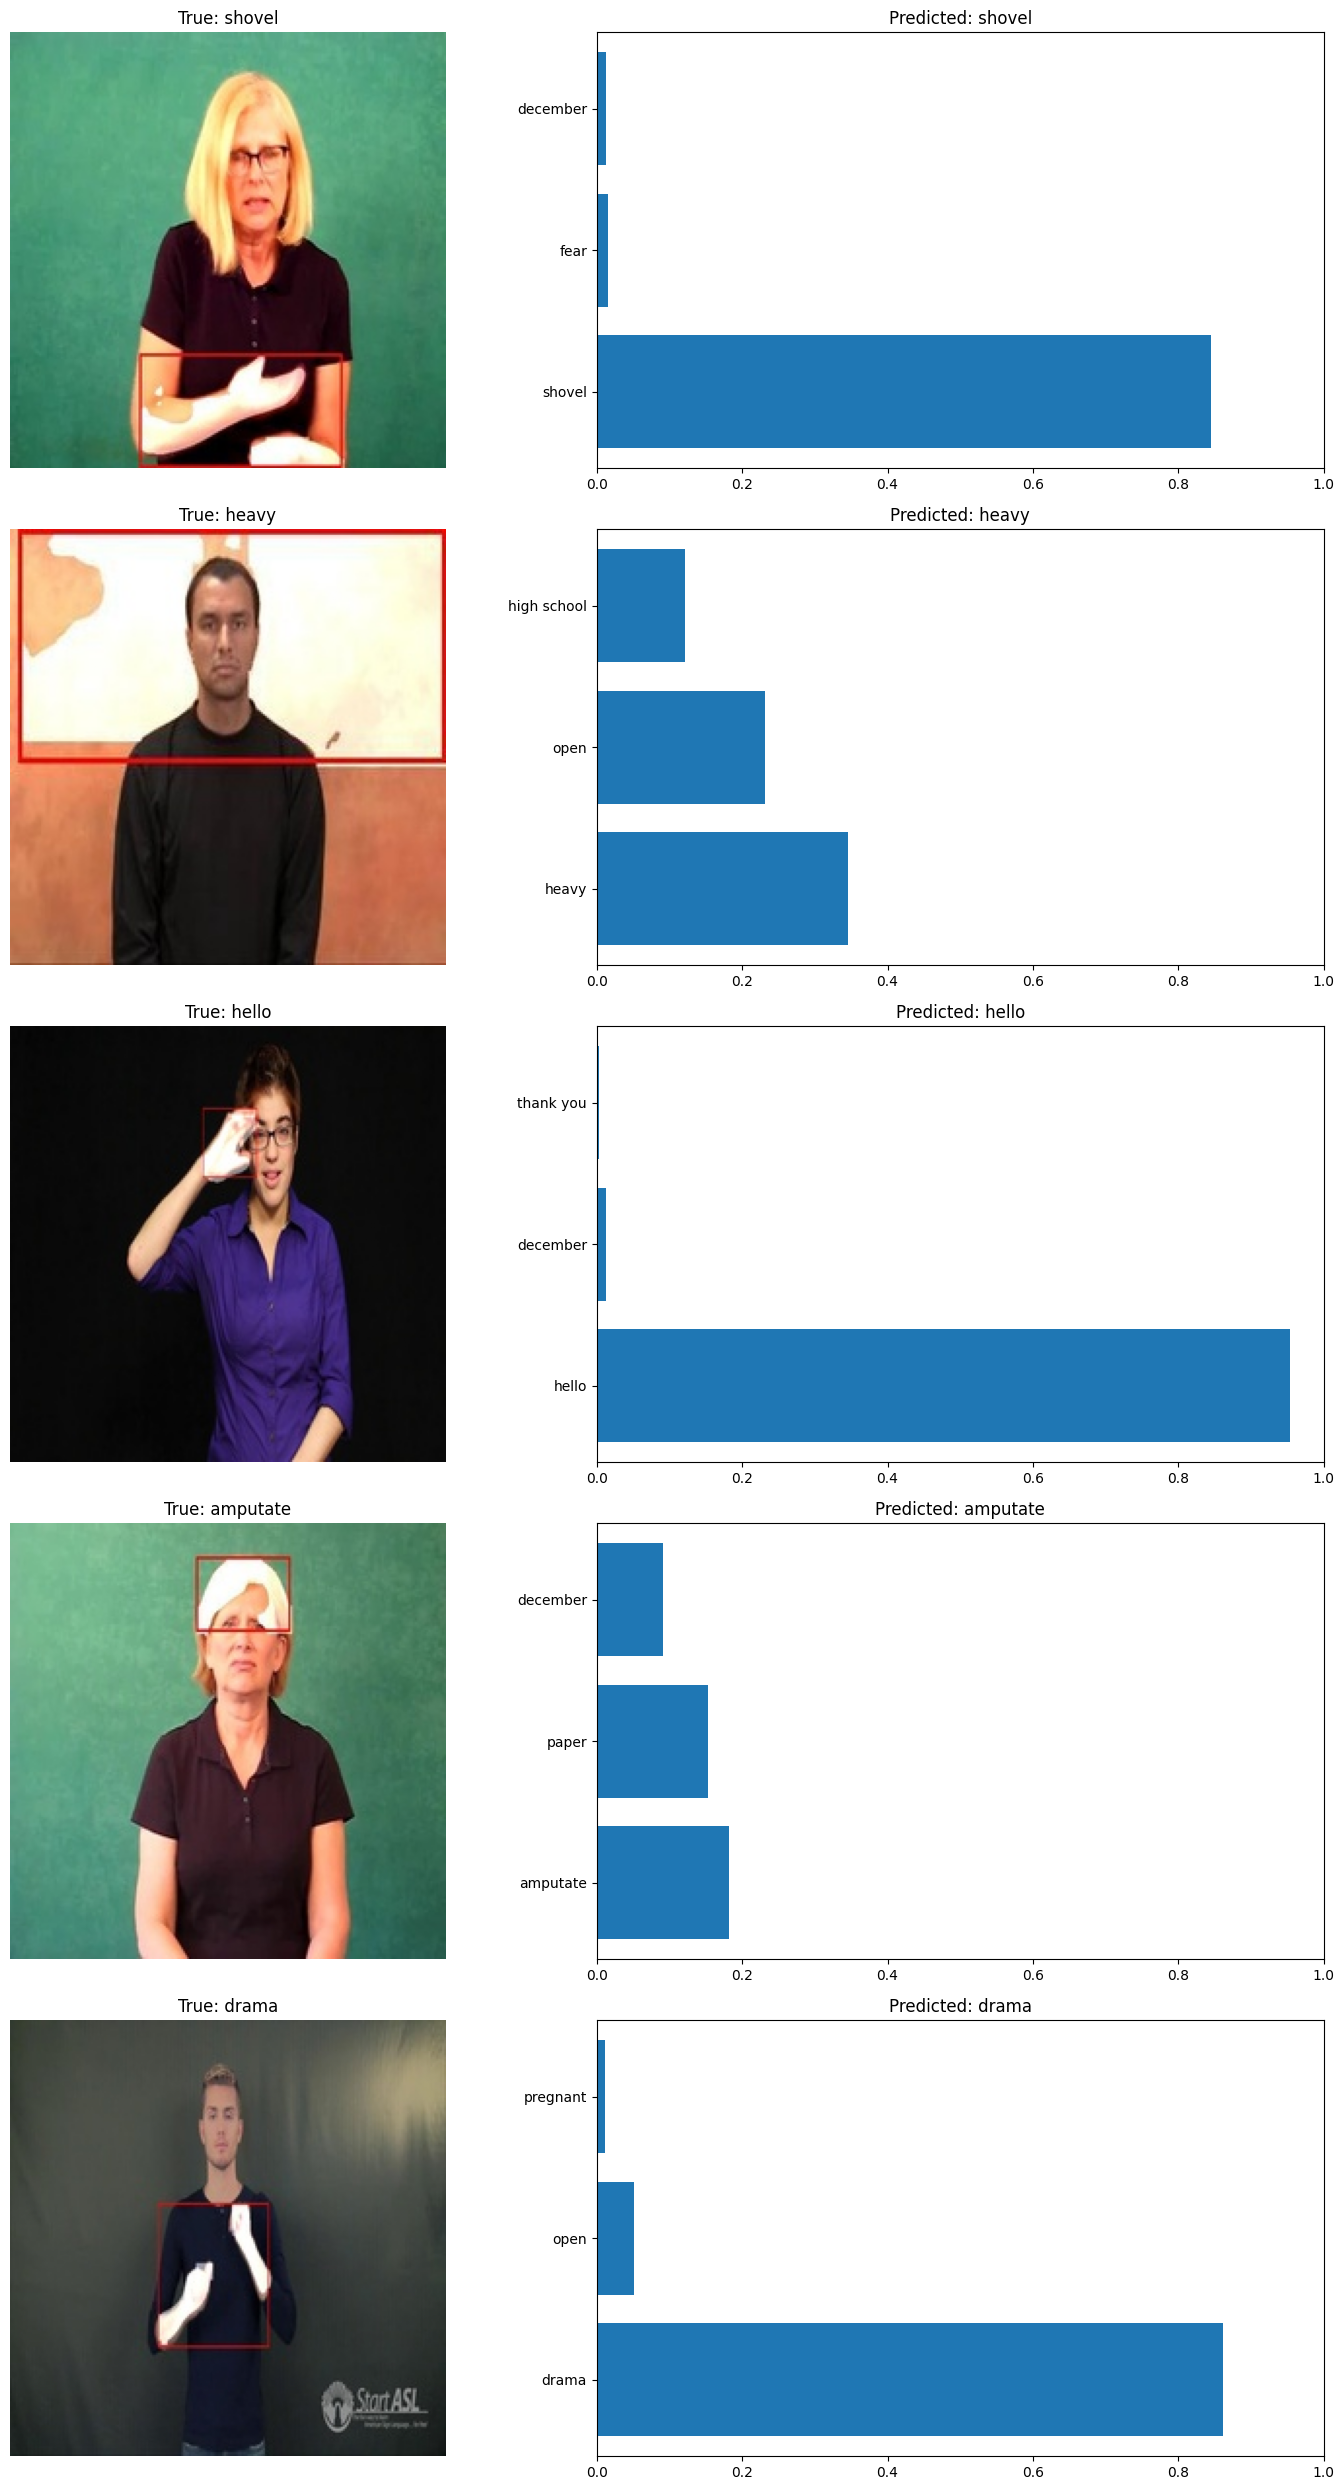

Evaluation complete!


In [1]:
# import os
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import models
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix

# # Set seeds for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)

# # Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# Validation dataset path
val_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_preprocessed\val"

# Load the saved model information
model_info = torch.load('final_resnet_wlasl.pth')
class_to_idx = model_info['class_to_idx']
num_classes = model_info['num_classes']

# Get class names from indices
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(num_classes)]

# Custom Dataset class for validation data
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.found_classes = set()
        
        # Get all image paths and labels
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            if class_name not in class_to_idx:
                print(f"Warning: Class {class_name} not in training data, skipping")
                continue
                
            class_idx = class_to_idx[class_name]
            self.found_classes.add(class_idx)
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith("_mask.jpg") or img_name.endswith("_mask.png"):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Load image and convert to tensor
        image = Image.open(img_path).convert('RGB')
        # Convert to tensor manually
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        image = image.transpose(2, 0, 1)  # Convert HWC to CHW format
        image = torch.FloatTensor(image)
        
        return image, label

# Create validation dataset
val_dataset = SignLanguageDataset(val_dir)
print(f"Validation samples: {len(val_dataset)}")

# Identify which classes are missing in validation
found_classes = val_dataset.found_classes
missing_classes = set(range(num_classes)) - found_classes
if missing_classes:
    print(f"Warning: {len(missing_classes)} classes from training not found in validation:")
    for idx in missing_classes:
        print(f"  - {idx_to_class[idx]}")

# Create validation data loader
batch_size = 16
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load ResNet-18 model
model = models.resnet18(weights=None)  # We'll load weights from our trained model

# Modify the final fully connected layer with dropout (same as training)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.7),
    nn.Linear(num_ftrs, num_classes)
)

# Load the best model weights
model.load_state_dict(torch.load('best_resnet_wlasl.pth'))
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Evaluate function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    
    return all_preds, all_labels

# Evaluate the model
print("Evaluating model on validation data...")
predictions, true_labels = evaluate_model(model, val_loader)

# Get actual class labels that appear in validation set for the report
val_class_indices = sorted(list(val_dataset.found_classes))
val_class_names = [class_names[i] for i in val_class_indices]

# Generate classification report with the labels that exist in validation
report = classification_report(true_labels, predictions, labels=val_class_indices, 
                              target_names=val_class_names, digits=4)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, class_indices):
    # Create mapping from original indices to new positions
    idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(class_indices)}
    
    # Map predictions and true labels to their new positions
    mapped_preds = [idx_map[p] for p in predictions]
    mapped_labels = [idx_map[l] for l in true_labels]
    
    cm = confusion_matrix(mapped_labels, mapped_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Get top confused classes
    class_accuracies = []
    for i, class_idx in enumerate(class_indices):
        class_mask = np.array(mapped_labels) == i
        if np.sum(class_mask) > 0:
            accuracy = np.sum(np.array(mapped_preds)[class_mask] == i) / np.sum(class_mask)
            class_accuracies.append((i, class_idx, accuracy))
    
    # Sort by accuracy (lowest first)
    sorted_classes = sorted(class_accuracies, key=lambda x: x[2])
    
    # Get top 20 worst-performing classes (or all if less than 20)
    num_to_show = min(20, len(sorted_classes))
    worst_classes_idx = [x[0] for x in sorted_classes[:num_to_show]]
    worst_class_names = [class_names[x[1]] for x in sorted_classes[:num_to_show]]
    
    # Create subset confusion matrix
    cm_subset = cm_norm[np.ix_(worst_classes_idx, worst_classes_idx)]
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_subset, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=worst_class_names, yticklabels=worst_class_names)
    plt.title('Confusion Matrix (Most Confused Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot per-class accuracy
def plot_class_accuracy(true_labels, predictions, class_names, class_indices):
    # Create mapping from original indices to new positions
    idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(class_indices)}
    
    # Map predictions and true labels to their new positions
    mapped_preds = [idx_map[p] for p in predictions]
    mapped_labels = [idx_map[l] for l in true_labels]
    
    # Calculate per-class accuracy
    class_accuracy = {}
    for i, class_idx in enumerate(class_indices):
        class_mask = np.array(mapped_labels) == i
        if np.sum(class_mask) > 0:
            accuracy = np.sum(np.array(mapped_preds)[class_mask] == i) / np.sum(class_mask)
            class_accuracy[class_names[class_idx]] = accuracy
    
    # Sort by accuracy
    sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1])
    classes = [x[0] for x in sorted_classes]
    accuracies = [x[1] for x in sorted_classes]
    
    plt.figure(figsize=(15, 8))
    plt.barh(range(len(classes)), accuracies, align='center')
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Accuracy')
    plt.ylabel('Class')
    plt.title('Validation Accuracy per Class')
    plt.tight_layout()
    plt.grid(axis='x')
    plt.savefig('class_accuracy.png')
    plt.show()

# Visualize predictions on a few validation samples
def visualize_predictions(model, dataset, class_names, num_samples=10):
    # Create a DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get a few samples
    samples = []
    for i, (inputs, labels) in enumerate(loader):
        if i >= num_samples:
            break
        samples.append((inputs, labels))
    
    # Make predictions and visualize
    plt.figure(figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(samples):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Get the actual image
            img = inputs.cpu().squeeze().permute(1, 2, 0).numpy()
            
            # Get top 3 predictions
            top_probs, top_classes = torch.topk(probs, 3)
            top_probs = top_probs.cpu().squeeze().numpy()
            top_classes = top_classes.cpu().squeeze().numpy()
            
            # Plot
            plt.subplot(num_samples, 2, 2*i+1)
            plt.imshow(img)
            plt.title(f"True: {class_names[labels.item()]}")
            plt.axis('off')
            
            plt.subplot(num_samples, 2, 2*i+2)
            y_pos = np.arange(3)
            plt.barh(y_pos, top_probs)
            plt.yticks(y_pos, [class_names[j] for j in top_classes])
            plt.title(f"Predicted: {class_names[preds.item()]}")
            plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Plot confusion matrix with the classes in validation set
plot_confusion_matrix(true_labels, predictions, class_names, val_class_indices)

# Plot per-class accuracy with the classes in validation set
plot_class_accuracy(true_labels, predictions, class_names, val_class_indices)

# Visualize predictions
visualize_predictions(model, val_dataset, class_names, num_samples=5)

print("Evaluation complete!")

# testing 

Using device: cuda:0
Test samples: 1196
Evaluating model on test data...
Test Accuracy: 88.96%

Top 5 best performing classes:
  abdomen: 100.00% (27/27)
  chapter: 100.00% (53/53)
  crazy: 100.00% (24/24)
  december: 100.00% (48/48)
  desert: 100.00% (28/28)

Bottom 5 worst performing classes:
  bracelet: 58.82% (10/17)
  angel: 50.00% (6/12)
  contact: 20.00% (10/50)
  listen: 20.00% (1/5)
  cute: 0.00% (0/2)

Classification Report:
              precision    recall  f1-score   support

     abdomen     1.0000    1.0000    1.0000        27
      action     1.0000    0.9118    0.9538        34
   alligator     1.0000    0.9231    0.9600        26
       alone     0.7500    0.6000    0.6667         5
    amputate     0.9524    0.8000    0.8696        25
       angel     1.0000    0.5000    0.6667        12
     benefit     1.0000    0.9615    0.9804        26
        bird     1.0000    0.7500    0.8571         8
        book     0.9286    0.9286    0.9286        14
    bracelet     0.7

C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

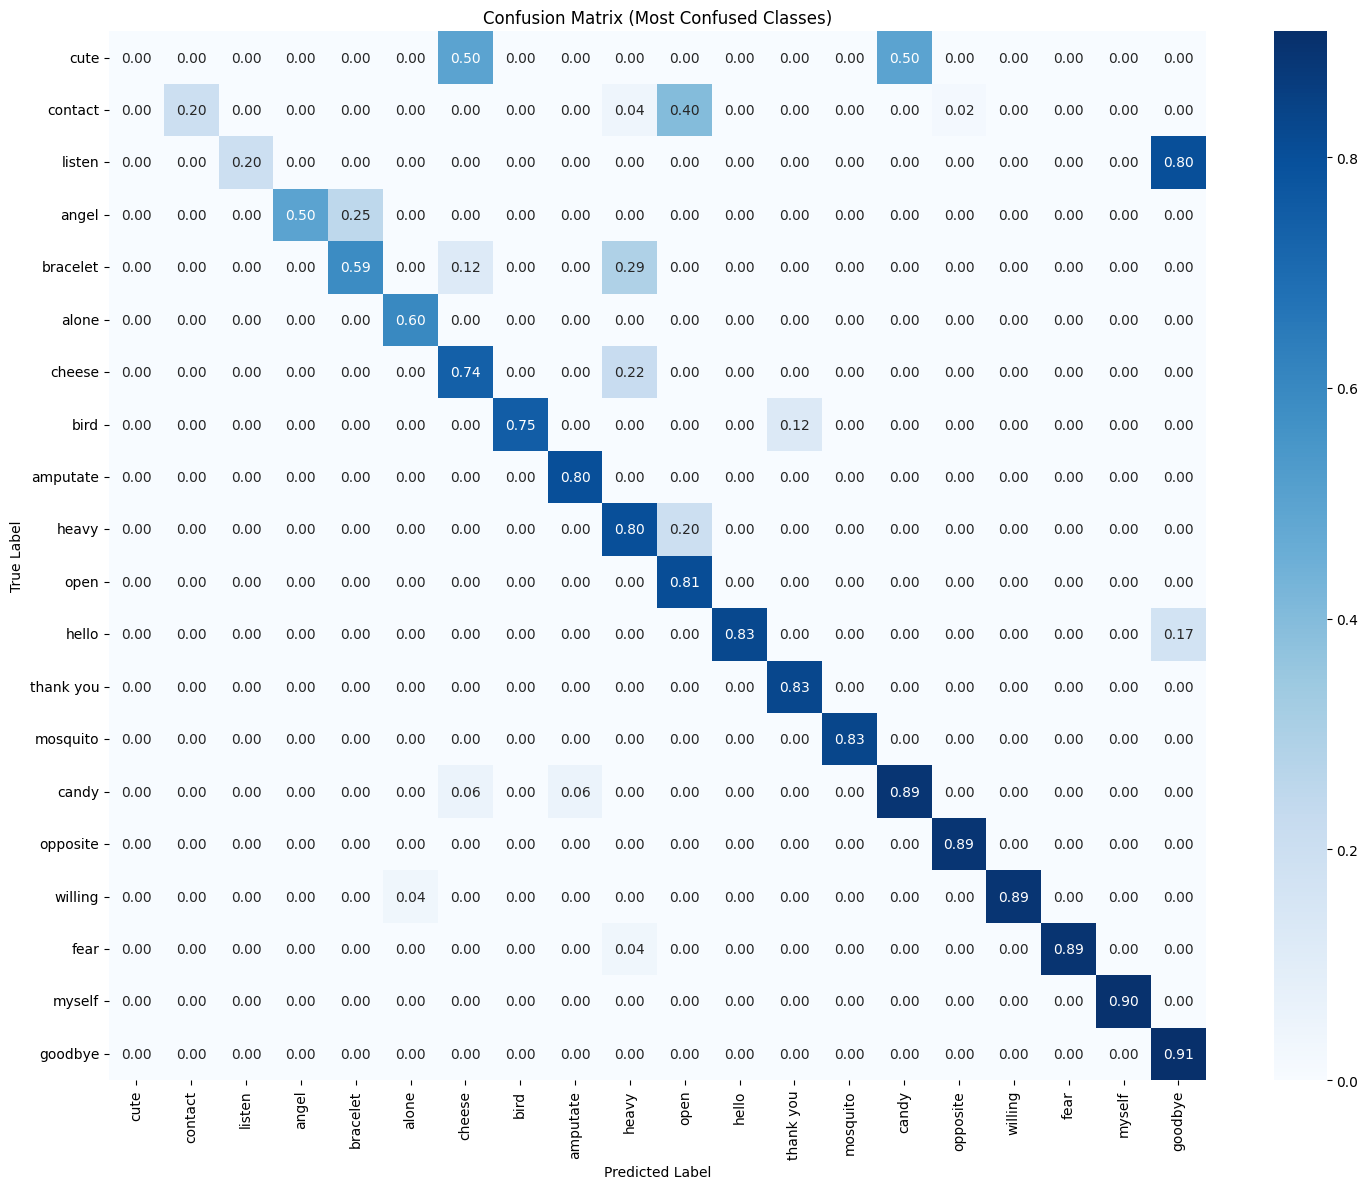

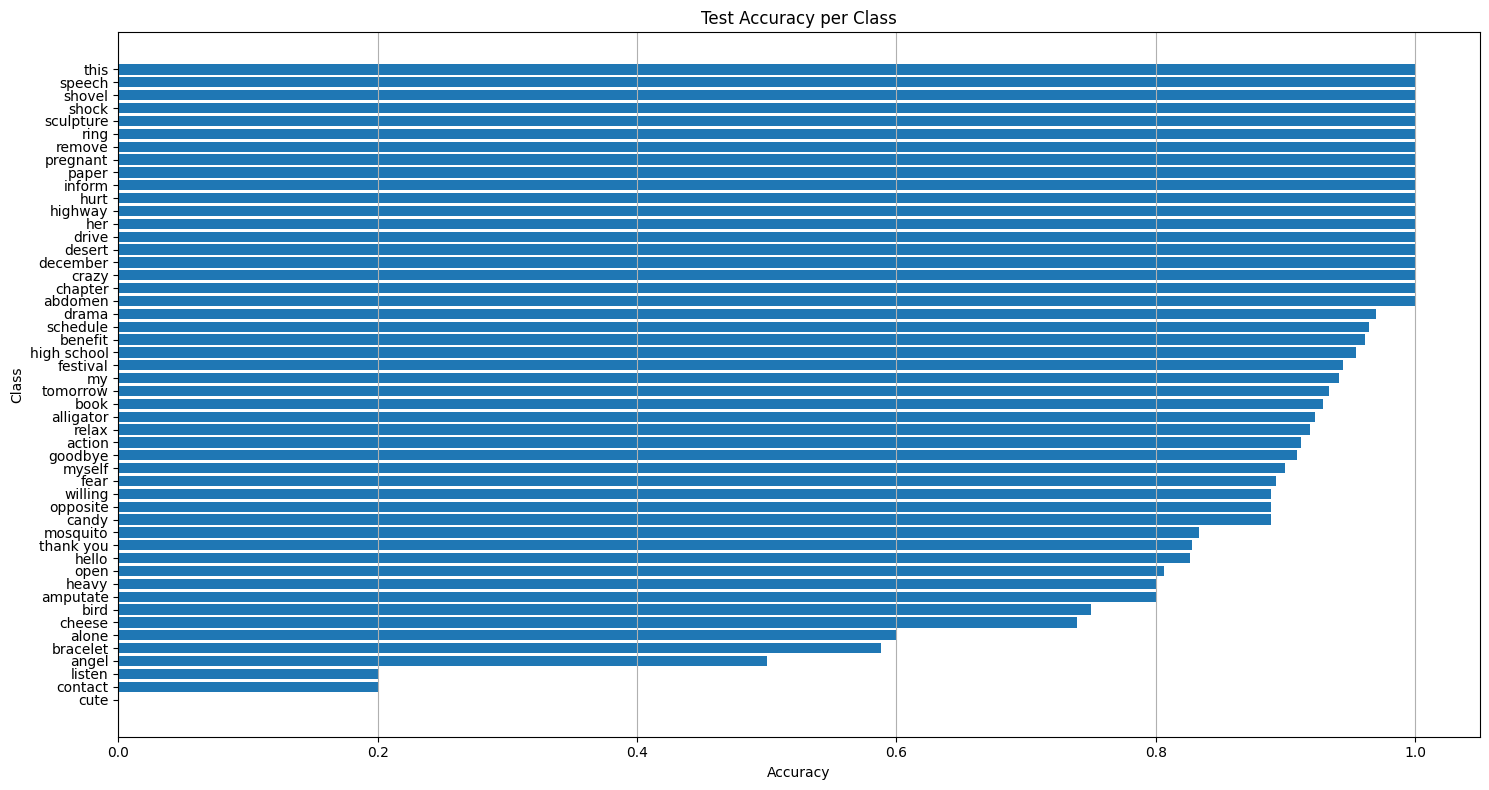

Generating ROC curves...


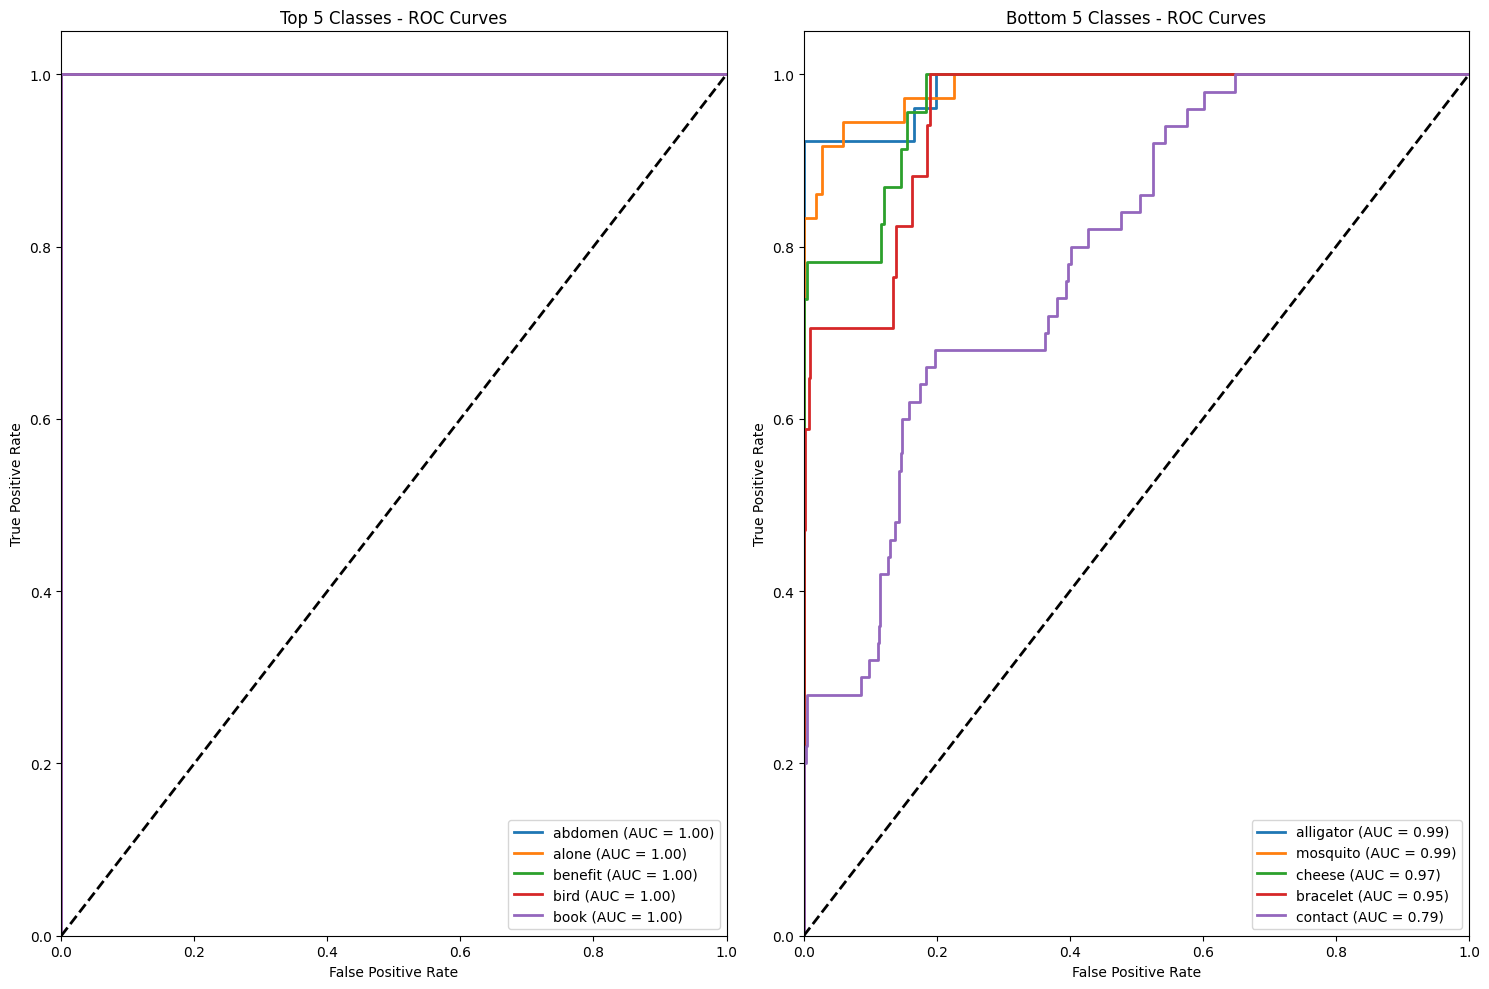

Test Evaluation complete!


In [2]:
# # import os
# # import torch
# # import torch.nn as nn
# # from torch.utils.data import Dataset, DataLoader
# # from torchvision import models
# # from PIL import Image
# # import numpy as np
# # import matplotlib.pyplot as plt
# # import seaborn as sns
# # from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# # from itertools import cycle

# # # Set seeds for reproducibility
# # torch.manual_seed(42)
# # np.random.seed(42)

# # Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# Test dataset path
test_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_preprocessed\test"

# Load the saved model information
model_info = torch.load('final_resnet_wlasl.pth')
class_to_idx = model_info['class_to_idx']
num_classes = model_info['num_classes']

# Get class names from indices
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(num_classes)]

# Custom Dataset class for test data
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.found_classes = set()
        
        # Get all image paths and labels
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            if class_name not in class_to_idx:
                print(f"Warning: Class {class_name} not in training data, skipping")
                continue
                
            class_idx = class_to_idx[class_name]
            self.found_classes.add(class_idx)
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith("_mask.jpg") or img_name.endswith("_mask.png"):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Load image and convert to tensor
        image = Image.open(img_path).convert('RGB')
        # Convert to tensor manually
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        image = image.transpose(2, 0, 1)  # Convert HWC to CHW format
        image = torch.FloatTensor(image)
        
        return image, label

# Create test dataset
test_dataset = SignLanguageDataset(test_dir)
print(f"Test samples: {len(test_dataset)}")

# Identify which classes are missing in test
found_classes = test_dataset.found_classes
missing_classes = set(range(num_classes)) - found_classes
if missing_classes:
    print(f"Warning: {len(missing_classes)} classes from training not found in test:")
    for idx in missing_classes:
        print(f"  - {idx_to_class[idx]}")

# Create test data loader
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load ResNet-18 model
model = models.resnet18(weights=None)  # We'll load weights from our trained model

# Modify the final fully connected layer with dropout (same as training)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.7),
    nn.Linear(num_ftrs, num_classes)
)

# Load the best model weights
model.load_state_dict(torch.load('best_resnet_wlasl.pth'))
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Evaluate function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    class_correct = {}
    class_total = {}
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            # Per-class accuracy
            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()
                
                if label not in class_total:
                    class_total[label] = 0
                    class_correct[label] = 0
                    
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Print per-class accuracy for top 5 and bottom 5
    print("\nTop 5 best performing classes:")
    class_accuracies = []
    for cls in class_total.keys():
        class_accuracies.append((cls, 100 * class_correct[cls] / class_total[cls]))
    
    sorted_classes = sorted(class_accuracies, key=lambda x: x[1], reverse=True)
    for i, (cls, acc) in enumerate(sorted_classes[:5]):
        print(f"  {idx_to_class[cls]}: {acc:.2f}% ({class_correct[cls]}/{class_total[cls]})")
    
    print("\nBottom 5 worst performing classes:")
    for i, (cls, acc) in enumerate(sorted_classes[-5:]):
        print(f"  {idx_to_class[cls]}: {acc:.2f}% ({class_correct[cls]}/{class_total[cls]})")
    
    return all_preds, all_labels

# Evaluate the model
print("Evaluating model on test data...")
predictions, true_labels = evaluate_model(model, test_loader)

# Get actual class labels that appear in test set for the report
test_class_indices = sorted(list(test_dataset.found_classes))
test_class_names = [class_names[i] for i in test_class_indices]

# Generate classification report with the labels that exist in test
report = classification_report(true_labels, predictions, labels=test_class_indices, 
                              target_names=test_class_names, digits=4)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, class_indices):
    # Create mapping from original indices to new positions
    idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(class_indices)}
    
    # Map predictions and true labels to their new positions
    mapped_preds = [idx_map[p] for p in predictions]
    mapped_labels = [idx_map[l] for l in true_labels]
    
    cm = confusion_matrix(mapped_labels, mapped_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Get top confused classes
    class_accuracies = []
    for i, class_idx in enumerate(class_indices):
        class_mask = np.array(mapped_labels) == i
        if np.sum(class_mask) > 0:
            accuracy = np.sum(np.array(mapped_preds)[class_mask] == i) / np.sum(class_mask)
            class_accuracies.append((i, class_idx, accuracy))
    
    # Sort by accuracy (lowest first)
    sorted_classes = sorted(class_accuracies, key=lambda x: x[2])
    
    # Get top 20 worst-performing classes (or all if less than 20)
    num_to_show = min(20, len(sorted_classes))
    worst_classes_idx = [x[0] for x in sorted_classes[:num_to_show]]
    worst_class_names = [class_names[x[1]] for x in sorted_classes[:num_to_show]]
    
    # Create subset confusion matrix
    cm_subset = cm_norm[np.ix_(worst_classes_idx, worst_classes_idx)]
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_subset, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=worst_class_names, yticklabels=worst_class_names)
    plt.title('Confusion Matrix (Most Confused Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('test_confusion_matrix.png')
    plt.show()

# Plot per-class accuracy
def plot_class_accuracy(true_labels, predictions, class_names, class_indices):
    # Create mapping from original indices to new positions
    idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(class_indices)}
    
    # Map predictions and true labels to their new positions
    mapped_preds = [idx_map[p] for p in predictions]
    mapped_labels = [idx_map[l] for l in true_labels]
    
    # Calculate per-class accuracy
    class_accuracy = {}
    for i, class_idx in enumerate(class_indices):
        class_mask = np.array(mapped_labels) == i
        if np.sum(class_mask) > 0:
            accuracy = np.sum(np.array(mapped_preds)[class_mask] == i) / np.sum(class_mask)
            class_accuracy[class_names[class_idx]] = accuracy
    
    # Sort by accuracy
    sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1])
    classes = [x[0] for x in sorted_classes]
    accuracies = [x[1] for x in sorted_classes]
    
    plt.figure(figsize=(15, 8))
    plt.barh(range(len(classes)), accuracies, align='center')
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Accuracy')
    plt.ylabel('Class')
    plt.title('Test Accuracy per Class')
    plt.tight_layout()
    plt.grid(axis='x')
    plt.savefig('test_class_accuracy.png')
    plt.show()

# Visualize predictions on a few test samples
def visualize_predictions(model, dataset, class_names, num_samples=10):
    # Create a DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get a few samples
    samples = []
    for i, (inputs, labels) in enumerate(loader):
        if i >= num_samples:
            break
        samples.append((inputs, labels))
    
    # Make predictions and visualize
    plt.figure(figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(samples):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Get the actual image
            img = inputs.cpu().squeeze().permute(1, 2, 0).numpy()
            
            # Get top 3 predictions
            top_probs, top_classes = torch.topk(probs, 3)
            top_probs = top_probs.cpu().squeeze().numpy()
            top_classes = top_classes.cpu().squeeze().numpy()
            
            # Plot
            plt.subplot(num_samples, 2, 2*i+1)
            plt.imshow(img)
            plt.title(f"True: {class_names[labels.item()]}")
            plt.axis('off')
            
            plt.subplot(num_samples, 2, 2*i+2)
            y_pos = np.arange(3)
            plt.barh(y_pos, top_probs)
            plt.yticks(y_pos, [class_names[j] for j in top_classes])
            plt.title(f"Predicted: {class_names[preds.item()]}")
            plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.savefig('test_prediction_samples.png')
    plt.show()

# Function to get all predictions and probabilities
def get_all_predictions(model, dataloader):
    y_true = []
    y_scores = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())
    
    return np.array(y_true), np.array(y_scores)

# Plot ROC curves
def plot_multiclass_roc(class_names, class_indices, y_true, y_scores):
    n_classes = len(class_indices)
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Calculate ROC curve and ROC area for each class
    for i, class_idx in enumerate(class_indices):
        # Binary encoding for each class
        y_binary = (y_true == class_idx).astype(int)
        
        # ROC curve for this class
        fpr[i], tpr[i], _ = roc_curve(y_binary, y_scores[:, class_idx])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Find best and worst classes by AUC
    class_aucs = [(i, idx, roc_auc[i]) for i, idx in enumerate(range(n_classes))]
    sorted_aucs = sorted(class_aucs, key=lambda x: x[2], reverse=True)
    
    # Plot best 5 classes
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    for i, class_idx, auc_val in sorted_aucs[:5]:
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[class_indices[i]]} (AUC = {auc_val:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Top 5 Classes - ROC Curves')
    plt.legend(loc="lower right")
    
    # Plot worst 5 classes
    plt.subplot(1, 2, 2)
    for i, class_idx, auc_val in sorted_aucs[-5:]:
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[class_indices[i]]} (AUC = {auc_val:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Bottom 5 Classes - ROC Curves')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig('test_roc_curves.png')
    plt.show()

# Plot confusion matrix with the classes in test set
plot_confusion_matrix(true_labels, predictions, class_names, test_class_indices)

# Plot per-class accuracy with the classes in test set
plot_class_accuracy(true_labels, predictions, class_names, test_class_indices)

# Visualize predictions
visualize_predictions(model, test_dataset, class_names, num_samples=5)

# Get all predictions for ROC curve
print("Generating ROC curves...")
y_true, y_scores = get_all_predictions(model, test_loader)

# Plot ROC curves
plot_multiclass_roc(class_names, test_class_indices, y_true, y_scores)

print("Test Evaluation complete!")

# Grad-CAM visualizations to understand model's classification process. 

In [43]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Register hooks to get gradients and activations from final conv layer
class GradCAM:
    def __init__(self, model, target_layer='layer4'):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        class_score = output[0, class_idx]
        class_score.backward()

        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_grads[i]

        cam = torch.sum(activations, dim=0).cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

def show_gradcam_on_image(image_np, cam, title='Grad-CAM'):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(image_np) / 255
    overlay = overlay / np.max(overlay)
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [46]:
# Initialize GradCAM object
gradcam = GradCAM(model)

# Select a few correct and incorrect predictions
sampled = random.sample(results, 3) + random.sample([r for r in results if not r['correct']], 3)

for res in sampled:
    img_path = res['img_path']
    true_label = res['true']
    pred_label = res['pred']
    class_idx = class_names.index(pred_label)

    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    img_np = np.array(img)
    input_tensor = torch.FloatTensor(np.transpose(img_np / 255.0, (2, 0, 1))).unsqueeze(0).to(device)

    # Generate CAM and show
    cam = gradcam.generate_cam(input_tensor, class_idx)
    show_gradcam_on_image(img_np, cam, title=f"True: {true_label} | Pred: {pred_label}")


# Caption Translation  

In [2]:
import os
import sys
import subprocess

def install_packages():
    """Install required packages for sign language translation project"""
    packages = [
        "torch",
        "torchvision",
        "tqdm", 
        "transformers",
        "matplotlib",
        "pillow",
        "numpy",
        "opencv-python",
        "torchcam"
    ]
    
    print(f"Python executable: {sys.executable}")
    print(f"Python version: {sys.version}")
    
    for package in packages:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ Successfully installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"✗ Failed to install {package}: {e}")
    
    print("\nAll installations complete!")

# Run the installation
install_packages()

Python executable: C:\Users\TTB\AppData\Local\Programs\Python\Python310\python.exe
Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Installing torch...
✓ Successfully installed torch
Installing torchvision...
✓ Successfully installed torchvision
Installing tqdm...
✓ Successfully installed tqdm
Installing transformers...
✓ Successfully installed transformers
Installing matplotlib...
✓ Successfully installed matplotlib
Installing pillow...
✓ Successfully installed pillow
Installing numpy...
✓ Successfully installed numpy
Installing opencv-python...
✓ Successfully installed opencv-python
Installing torchcam...
✓ Successfully installed torchcam

All installations complete!


In [ ]:
# verifying Devnagri font installation in the system 

In [5]:
import matplotlib.font_manager as fm

# Setup Devanagari font for Hindi rendering
try:
    # Search for the installed Devanagari font
    font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    hindi_font_path = None

    for path in font_paths:
        if "noto" in path.lower() and "devanagari" in path.lower():
            hindi_font_path = path
            break

    if hindi_font_path:
        hindi_font = fm.FontProperties(fname=hindi_font_path)
        print(f"Using Devanagari font: {hindi_font_path}")
    else:
        raise RuntimeError("Devanagari font not found")
except Exception as e:
    print(f"Font setup failed: {e}")
    hindi_font = None


Using Devanagari font: C:\Users\TTB\AppData\Local\Microsoft\Windows\Fonts\NotoSansDevanagari-VariableFont_wdth,wght.ttf


Using device: cuda


C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0
100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 12.55it/s]


Class  Accuracy (%)  BLEU Score Hindi Translation Example
0       abdomen        100.00       1.000                       पेट
1        action         91.18       0.912                    क्रिया
2     alligator         92.31       0.923                     घ॑याल
3         alone         60.00       0.600                     अकेला
4      amputate         80.00       0.800                अंगविच्छेद
5         angel         50.00       0.500                    देवदूत
6       benefit         96.15       0.962                       लाभ
7          bird         75.00       0.750                     पक्षी
8          book         92.86       0.929                     किताब
9      bracelet         58.82       0.588                      कंगन
10        candy         88.89       0.889                     मिठाई
11      chapter        100.00       1.000                    अध्याय
12       cheese         73.91       0.739                      पनीर
13      contact         20.00       0.200                    संपर्क
14        crazy        100.00       1.000                      पागल
15         cute          0.00       0.000                     मिठाई
16     december        100.00       1.000                    दिसंबर
17       desert        100.00       1.000                 रेगिस्तान
18        drama         97.01       0.970                      नाटक
19        drive        100.00       1.000                     चालना
20         fear         89.29       0.893                        डर
21     festival         94.44       0.944                   त्यौहार
22      goodbye         90.91       0.909                    अलविदा
23        heavy         80.00       0.800                      भारी
24        hello         82.61       0.826                    नमस्ते
25          her        100.00       1.000                      उसकी
26  high school         95.45       0.955             उच्च विद्यालय
27      highway        100.00       1.000                  राजमार्ग
28         hurt        100.00       1.000                       चोट
29       inform        100.00       1.000                सूचित करना
30       listen         20.00       0.200                     सुनना
31     mosquito         83.33       0.833                     मच्छर
32           my         94.12       0.941                      मेरा
33       myself         90.00       0.900                       खुद
34         open         80.65       0.806                     खोलना
35     opposite         88.89       0.889                    विपरीत
36        paper        100.00       1.000                     कागज़
37     pregnant        100.00       1.000                   गर्भवती
38        relax         91.89       0.919                 आराम करना
39       remove        100.00       1.000                     हटाना
40         ring        100.00       1.000                    अंगूठी
41     schedule         96.43       0.964                समय सारिणी
42    sculpture        100.00       1.000                    मूर्ति
43        shock        100.00       1.000                      आघात
44       shovel        100.00       1.000                     फावड़ा
45       speech        100.00       1.000                      भाषण
46    thank you         82.76       0.828                   धन्यवाद
47         this        100.00       1.000                        यह
48     tomorrow         93.33       0.933                        कल
49      willing         88.89       0.889                    इच्छुक

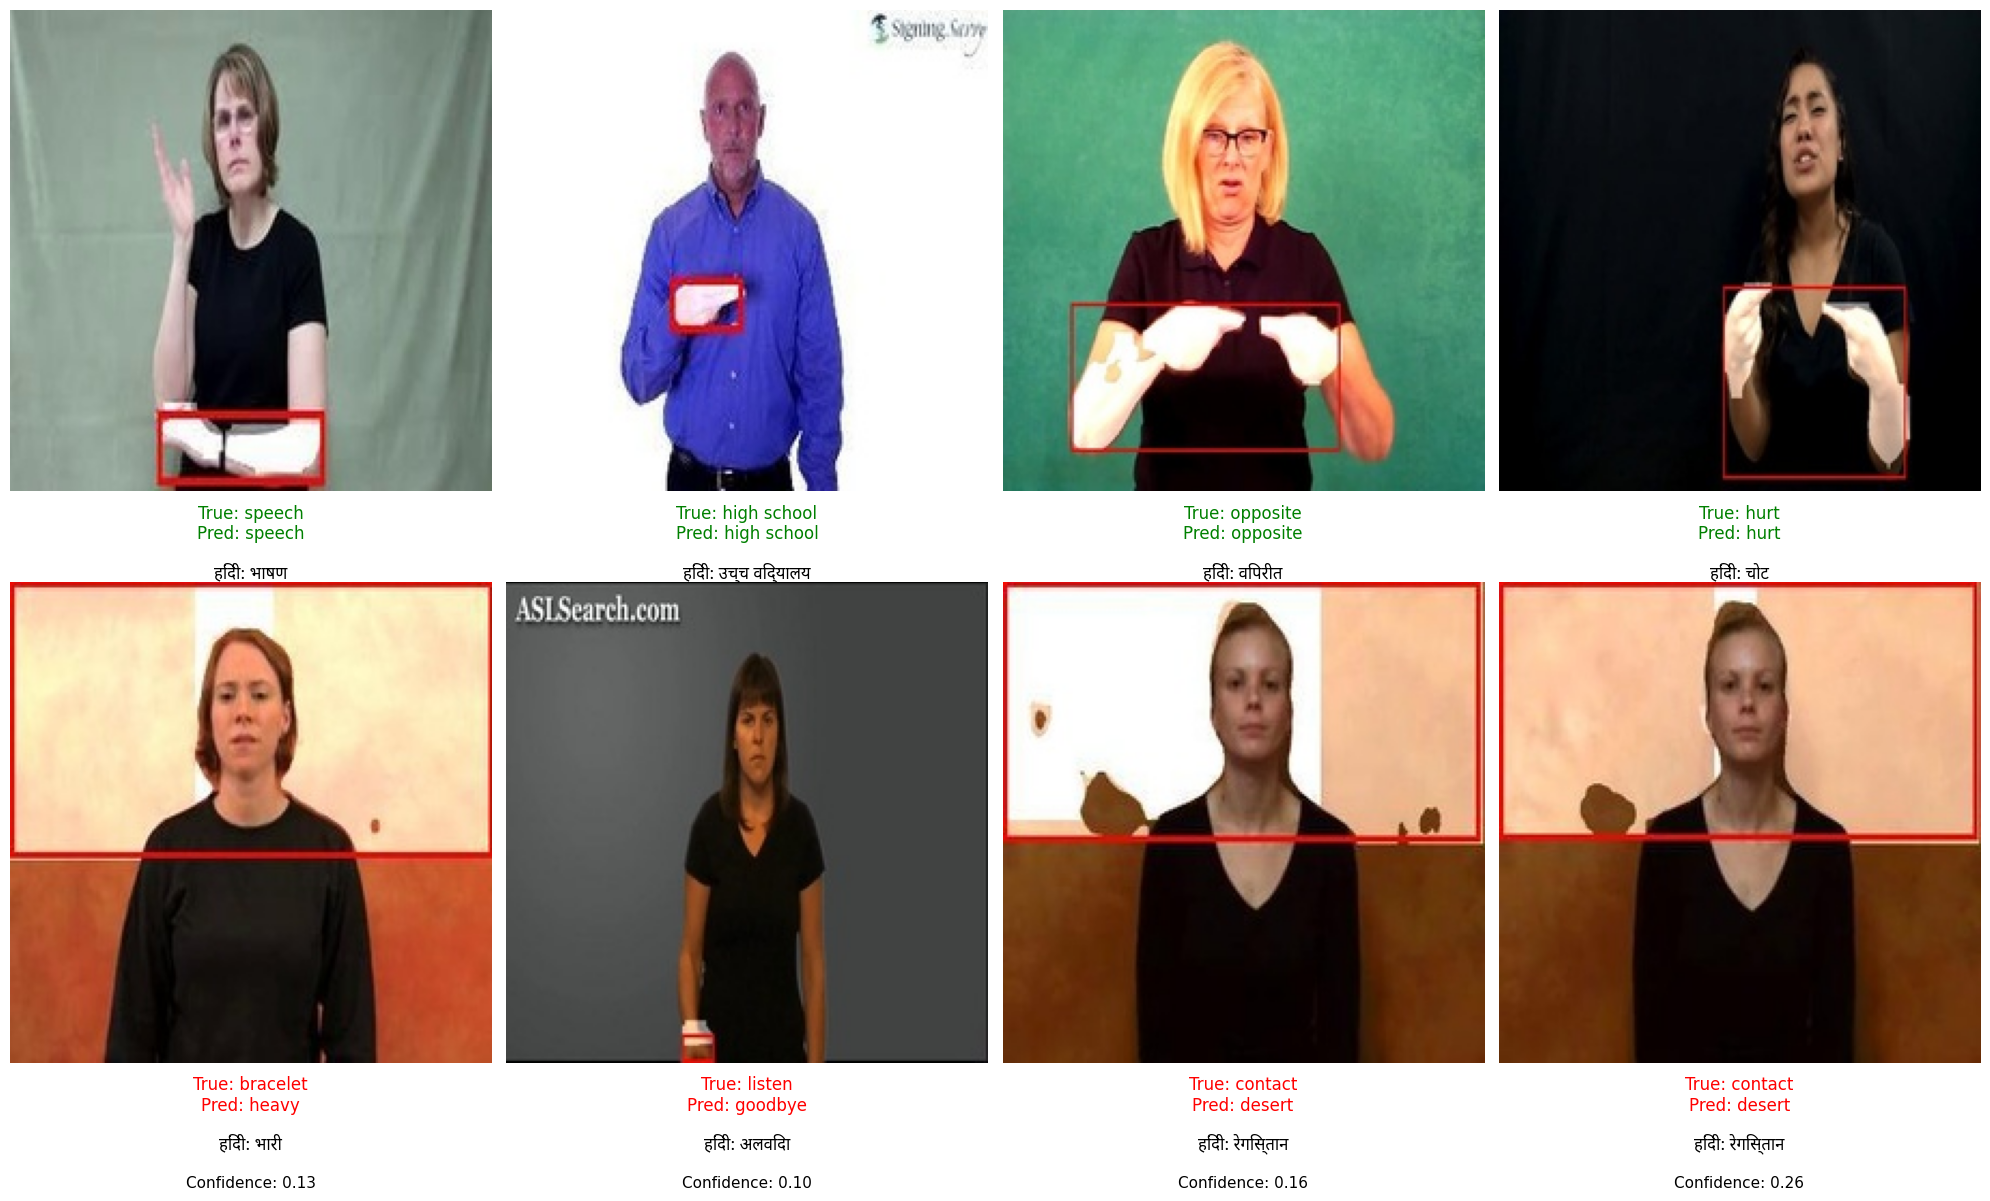

In [42]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

test_dir = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\DeepLearning\DL_project\project\Datasets\wlasl\custom_wlasl_preprocessed\test"
model_path = "best_resnet_wlasl.pth"

# Hindi dictionary
hindi_dict = {"action": "\u0915\u094d\u0930\u093f\u092f\u093e", "alligator": "\u0918\u0951\u092f\u093e\u0932", "alone": "\u0905\u0915\u0947\u0932\u093e", "amputate": "\u0905\u0902\u0917\u0935\u093f\u091a\u094d\u091b\u0947\u0926", "angel": "\u0926\u0947\u0935\u0926\u0942\u0924", "benefit": "\u0932\u093e\u092d", "bird": "\u092a\u0915\u094d\u0937\u0940", "bracelet": "\u0915\u0902\u0917\u0928", "candy": "\u092e\u093f\u0920\u093e\u0908", "chapter": "\u0905\u0927\u094d\u092f\u093e\u092f", "cheese": "\u092a\u0928\u0940\u0930", "contact": "\u0938\u0902\u092a\u0930\u094d\u0915", "crazy": "\u092a\u093e\u0917\u0932", "cute": "\u092a\u094d\u092f\u093e\u0930\u093e", "december": "\u0926\u093f\u0938\u0902\u092c\u0930", "desert": "\u0930\u0947\u0917\u093f\u0938\u094d\u0924\u093e\u0928", "drama": "\u0928\u093e\u091f\u0915", "drive": "\u091a\u093e\u0932\u0928\u093e", "fear": "\u0921\u0930", "festival": "\u0924\u094d\u092f\u094c\u0939\u093e\u0930", "goodbye": "\u0905\u0932\u0935\u093f\u0926\u093e", "heavy": "\u092d\u093e\u0930\u0940", "hello": "\u0928\u092e\u0938\u094d\u0924\u0947", "her": "\u0909\u0938\u0915\u0940", "high school": "\u0909\u091a\u094d\u091a \u0935\u093f\u0926\u094d\u092f\u093e\u0932\u092f", "highway": "\u0930\u093e\u091c\u092e\u093e\u0930\u094d\u0917", "hurt": "\u091a\u094b\u091f", "inform": "\u0938\u0942\u091a\u093f\u0924 \u0915\u0930\u0928\u093e", "listen": "\u0938\u0941\u0928\u0928\u093e", "mosquito": "\u092e\u091a\u094d\u091b\u0930", "my": "\u092e\u0947\u0930\u093e", "myself": "\u0916\u0941\u0926", "open": "\u0916\u094b\u0932\u0928\u093e", "opposite": "\u0935\u093f\u092a\u0930\u0940\u0924", "paper": "\u0915\u093e\u0917\u091c\u093c", "pregnant": "\u0917\u0930\u094d\u092d\u0935\u0924\u0940", "relax": "\u0906\u0930\u093e\u092e \u0915\u0930\u0928\u093e", "remove": "\u0939\u091f\u093e\u0928\u093e", "ring": "\u0905\u0902\u0917\u0942\u0920\u0940", "schedule": "\u0938\u092e\u092f \u0938\u093e\u0930\u093f\u0923\u0940", "sculpture": "\u092e\u0942\u0930\u094d\u0924\u093f", "shock": "\u0906\u0918\u093e\u0924", "shovel": "\u092b\u093e\u0935\u095c\u093e", "speech": "\u092d\u093e\u0937\u0923", "thank you": "\u0927\u0928\u094d\u092f\u0935\u093e\u0926", "this": "\u092f\u0939", "tomorrow": "\u0915\u0932", "willing": "\u0907\u091a\u094d\u091b\u0941\u0915"}

# Load translator and font
try:
    translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")
except:
    translator = None
fonts = [f for f in fm.findSystemFonts() if 'devanagari' in f.lower() or 'noto' in f.lower()]
hindi_font = fm.FontProperties(fname=fonts[0] if fonts else None)

# Dataset class
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for fname in os.listdir(class_dir):
                    if fname.endswith("_mask.jpg") or fname.endswith("_mask.png"):
                        self.samples.append((os.path.join(class_dir, fname), class_name))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.transpose(np.array(img) / 255.0, (2, 0, 1))
        return torch.FloatTensor(img), label, img_path

def load_model(path):
    classes = get_class_names_from_directory(test_dir)
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.fc.in_features, len(classes)))
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
    return model.to(device).eval(), classes

def get_class_names_from_directory(directory):
    return sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])

def translate_to_hindi(gloss):
    gloss_norm = gloss.lower().strip()
    if gloss_norm in hindi_dict:
        return hindi_dict[gloss_norm]
    elif translator:
        try:
            result = translator(gloss_norm)
            return result[0]['translation_text']
        except:
            return "[\u0905\u0928\u0941\u0935\u093e\u0926 \u0935\u093f\u092b\u0932]"
    return "[\u0905\u0928\u0941\u0935\u093e\u0926 \u0935\u093f\u092b\u0932]"

def visualize_predictions(results, correct_samples=4, incorrect_samples=4):
    correct = [r for r in results if r['correct']]
    incorrect = [r for r in results if not r['correct']]
    
    random_correct = random.sample(correct, min(correct_samples, len(correct)))
    random_incorrect = random.sample(incorrect, min(incorrect_samples, len(incorrect)))
    
    selected = random_correct + random_incorrect
    num_total = len(selected)
    num_cols = min(4, num_total)
    num_rows = int(np.ceil(num_total / num_cols))

    plt.figure(figsize=(5 * num_cols, 6 * num_rows))
    
    for i, res in enumerate(selected):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.axis("off")
        img = Image.open(res['img_path']).convert("RGB")
        ax.imshow(np.array(img))

        # Labeling with color
        label_color = "green" if res['correct'] else "red"
        ax.text(0.5, -0.10, f"True: {res['true']}\nPred: {res['pred']}", 
                color=label_color, fontsize=12, ha='center', transform=ax.transAxes)
        
        ax.text(0.5, -0.18, f"हिंदी: {res['hindi']}",
                fontproperties=hindi_font, fontsize=12, ha='center', transform=ax.transAxes)
        
        ax.text(0.5, -0.26, f"Confidence: {res['confidence']:.2f}",
                fontsize=11, ha='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.savefig("correct_incorrect_class_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()




# Run inference
model, class_names = load_model(model_path)
test_dataset = SignLanguageDataset(test_dir)
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
results = []
smoothie = SmoothingFunction().method4

with torch.no_grad():
    for images, labels, paths in tqdm(dataloader):
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        for i in range(images.shape[0]):
            pred_label = class_names[preds[i]]
            true_label = labels[i]
            hindi_translation = translate_to_hindi(pred_label)
            bleu = sentence_bleu([true_label.lower().split()], pred_label.lower().split(), weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
            results.append({
                'true': true_label,
                'pred': pred_label,
                'hindi': hindi_translation,
                'confidence': probs[i][preds[i]].item(),
                'correct': pred_label == true_label,
                'img_path': paths[i],
                'bleu': bleu
            })

# Evaluate and display
results_df = pd.DataFrame(results)
acc_per_class = results_df.groupby("true")["correct"].mean() * 100
bleu_per_class = results_df.groupby("true")["bleu"].mean()
sample_translations = (
    results_df[results_df["correct"]].groupby("true")["hindi"].first()
    .combine_first(results_df.groupby("true")["hindi"].first())
)
summary_df = pd.DataFrame({
    "Accuracy (%)": acc_per_class.round(2),
    "BLEU Score": bleu_per_class.round(3),
    "Hindi Translation Example": sample_translations
}).reset_index().rename(columns={"true": "Class"})
display(summary_df)
summary_df.to_csv("classwise_accuracy_bleu_translation.csv", index=False)

# Visualize
# Call the new visualization
visualize_predictions(results, correct_samples=4, incorrect_samples=4)
